<a href="https://colab.research.google.com/github/ameliachoi/dacon-study-FUNDA/blob/master/dacon_funda_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON FUNDA : Predict Market Sales

## Index

1. Data load & Resampling
2. EDA
3. Modeling - Time Series

- [번외] 시계열 데이터 요소분해와 정상화
- [번회] 시계열 군집분석

## Data Field

- `store_id` : 상점 고유 아이디
- `card_id` : 사용한 카드의 고유 아이디
- `card_company` : 비식별화된 카드 회사
- `transacted_date` : 거래 날짜
- `transacted_time` : 거래 시간(시:분)
- `installment_term` : 할부 개월 수 (포인트 사용 시 (60개월 + 실제 할부개원)을 할부개월수에 기재한다)
- `region` : 상점의 지역
- `type_of_business` : 상점의 업종
- `amount` : 거래액(단위는 원이 아님)

---

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# basic setting
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.metrics import make_scorer

# 시계열
import statsmodels
from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# deep neural network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

# setting
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format 


### Evaluate Metric

- MAE(Mean Absolute Error) : 절대값 오차의 평균
- Validation을 위한 함수 생성 및 make scorer


In [ ]:
def mae(prediction, correct):
  prediction = np.array(prediction)
  correct = np.array(correct)

  difference = correct - prediction
  abs_val = abs(difference)

  score = abs_val.mean()

  return score

mae_scorer = make_scorer(mae)
mae_scorer

make_scorer(mae)

### Step 1. Data Load & Resampling

#### Issue

1. 예측해야 하는 범위는 3개월인데 데이터는 시간 단위로 나뉘어져 있음

- 월 단위로 resampling 후, forecast 범위를 3개월로 지정해야 해결

2. 1967개의 `store_id`가 각각 trend와 seasonality를 가지고 있음

- 같은 알고리즘에서 각 `store_id`별로 parameter 조절

3. 예측 날짜는 2019-03 ~ 2019-05로 동일하나, 제공 데이터의 마지막 날짜는 차이가 존재함

- 마지막 날짜부터 3개월만 예측하다 제출

- 예측 기간이 길어질수록 오차가 크게 발생해 바로 뒤 3개월만 예측하는 것이 정확도가 높았음

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data09/funda_train.csv')
df_sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data09/submission.csv')

In [ ]:
df_train.head()

store_id  card_id card_company transacted_date transacted_time  \
0         0        0            b      2016-06-01           13:13   
1         0        1            h      2016-06-01           18:12   
2         0        2            c      2016-06-01           18:52   
3         0        3            a      2016-06-01           20:22   
4         0        4            c      2016-06-02           11:06   

   installment_term region type_of_business     amount  
0                 0    NaN           기타 미용업 1857.14286  
1                 0    NaN           기타 미용업  857.14286  
2                 0    NaN           기타 미용업 2000.00000  
3                 0    NaN           기타 미용업 7857.14286  
4                 0    NaN           기타 미용업 2000.00000

In [ ]:
df_train.shape, df_sub.shape

((6556613, 9), (1967, 2))

In [ ]:
df_train.columns

Index(['store_id', 'card_id', 'card_company', 'transacted_date',
       'transacted_time', 'installment_term', 'region', 'type_of_business',
       'amount'],
      dtype='object')

In [ ]:
# datetime으로 데이터 타입 바꾸기
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date'])

In [ ]:
df_train.head()

store_id  card_id card_company transacted_date transacted_time  \
0         0        0            b      2016-06-01           13:13   
1         0        1            h      2016-06-01           18:12   
2         0        2            c      2016-06-01           18:52   
3         0        3            a      2016-06-01           20:22   
4         0        4            c      2016-06-02           11:06   

   installment_term region type_of_business     amount  
0                 0    NaN           기타 미용업 1857.14286  
1                 0    NaN           기타 미용업  857.14286  
2                 0    NaN           기타 미용업 2000.00000  
3                 0    NaN           기타 미용업 7857.14286  
4                 0    NaN           기타 미용업 2000.00000

In [ ]:
frame_info = [(col, len(df_train[col].unique()), df_train[col].isnull().sum(), df_train[col].dtype, df_train[col].unique()[:5]) for col in df_train.columns]
df_info = pd.DataFrame(frame_info, columns=['name', 'num_of_unique', 'num_of_nan', 'type', 'front5_values'])

In [ ]:
df_info

name  num_of_unique  num_of_nan            type  \
0          store_id           1967           0           int64   
1           card_id        3950001           0           int64   
2      card_company              8           0          object   
3   transacted_date           1003           0  datetime64[ns]   
4   transacted_time           1440           0          object   
5  installment_term             34           0           int64   
6            region            181     2042766          object   
7  type_of_business            146     3952609          object   
8            amount          30551           0         float64   

                                       front5_values  
0                                    [0, 1, 2, 4, 5]  
1                                    [0, 1, 2, 3, 4]  
2                                    [b, h, c, a, f]  
3  [2016-06-01T00:00:00.000000000, 2016-06-02T00:...  
4                [13:13, 18:12, 18:52, 20:22, 11:06]  
5                                   [0, 2, 3, 60, 4]  
6              [nan, 서울 종로구, 충북 충주시, 부산 동래구, 경기 평택시]  
7  [기타 미용업, nan, 의복 액세서리 및 모조 장신구 도매업, 한식 음식점업, 배...  
8  [1857.142857142857, 857.1428571428571, 2000.0,...

#### 시계열 분석을 위해 date 정보 index로 변환

In [ ]:
df_train = df_train.set_index('transacted_date')
df_train.head(3)

store_id  card_id card_company transacted_time  \
transacted_date                                                   
2016-06-01              0        0            b           13:13   
2016-06-01              0        1            h           18:12   
2016-06-01              0        2            c           18:52   

                 installment_term region type_of_business     amount  
transacted_date                                                       
2016-06-01                      0    NaN           기타 미용업 1857.14286  
2016-06-01                      0    NaN           기타 미용업  857.14286  
2016-06-01                      0    NaN           기타 미용업 2000.00000

#### 시간 단위로 나뉘어져 있는 데이터 일단위로 resampling

- `store_id` / `region` / `type_of_business` :  기존과 동일
- `day_of_week` : 각 요일을 나타내는 숫자. 월요일은 0, 일요일은 6.
- `business_day` : working day 여부. 1이면 working day.
- `num_of_pay` : 일 결제 건수. `card_id`의 count로 생성
- `num_of_revisit` : 단골 방문 횟수. `card_id`의 value 중 count >= 3 value의 결제 건수
- `installment_term` : 일 총 할부 개월 수, 기존 `installment_term`의 합. (수정)
- `amount` : 일 매출액. 기존 amount의 합. (수정)

In [ ]:
def resample_day(train_df):
  df_day = pd.DataFrame()

  for i in train_df['store_id'].unique():
    df_num = train_df[train_df['store_id']==i] # store_id 횟수 count

    # 'card_id'의 일별 counting을 통해 일 거래 횟수 확인
    # resample 함수의 rule='d'인 경우 일별 그룹이 가능해지고, count함수를 통해 unique값별로 빈도수 생성
    count_cols = df_num['card_id'].resample(rule='d').count().rename('num_of_pay')

    # 'card_id' value count >= 3이면 단골로 판단하고 단골 방문 횟수 확인
    revisit_idx = df_num['card_id'].value_counts().reset_index().query('card_id > 2')['index'].values
    revisit_ct = df_num[df_num['card_id'].isin(revisit_idx)]['card_id'].resample(rule='d').count().rename('num_of_revisit')

    # 할부 개월수와 매출액은 일단위로 합
    sum_cols = df_num[['installment_term', 'amount']].resample(rule='d').sum()
    df_num_day = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)

    # 매장 id, 지역, 업종 분류 추가
    df_num_day.insert(0, 'store_id', i)
    df_num_day.insert(4, 'region', df_num[df_num['store_id']==i]['region'].unique()[0])
    df_num_day.insert(5, 'type_of_business', df_num[df_num['store_id']==i]['type_of_business'].unique()[0])

    df_day = pd.concat([df_day, df_num_day], axis=0)

  df_day.insert(1, 'day_of_week', df_day.index.dayofweek) #df_day가 일별로 묶여 index에 들어가있음
  df_day.insert(2, 'business_day', df_day['day_of_week'].replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)
  df_day['num_of_revisit'].fillna(0, inplace=True)

  return df_day

In [ ]:
%%time
df_day = resample_day(df_train)

CPU times: user 3min 30s, sys: 3.51 s, total: 3min 33s
Wall time: 3min 33s


In [ ]:
df_day.head()

store_id  day_of_week  business_day  num_of_pay  \
transacted_date                                                    
2016-06-01              0            2             1           4   
2016-06-02              0            3             1           7   
2016-06-03              0            4             1           3   
2016-06-04              0            5             0           7   
2016-06-05              0            6             0           3   

                 num_of_revisit  installment_term region type_of_business  \
transacted_date                                                             
2016-06-01              4.00000                 0    NaN           기타 미용업   
2016-06-02              3.00000                 0    NaN           기타 미용업   
2016-06-03              2.00000                 0    NaN           기타 미용업   
2016-06-04              3.00000                 0    NaN           기타 미용업   
2016-06-05              3.00000                 0    NaN           기타 미용업   

                     amount  
transacted_date              
2016-06-01      12571.42857  
2016-06-02      40571.42857  
2016-06-03      18142.85714  
2016-06-04      31714.28571  
2016-06-05      10428.57143

In [ ]:
df_day.isnull().sum()

store_id                  0
day_of_week               0
business_day              0
num_of_pay                0
num_of_revisit            0
installment_term          0
region               629927
type_of_business    1087791
amount                    0
dtype: int64

In [ ]:
df_day.to_csv('preprocessed.csv')

#### 각 column간 상관관계 확인

In [ ]:
daily_corr = df_day.corr()
daily_corr

store_id  day_of_week  business_day  num_of_pay  \
store_id           1.00000     -0.00004       0.00001     0.04237   
day_of_week       -0.00004      1.00000      -0.79052     0.01672   
business_day       0.00001     -0.79052       1.00000    -0.00460   
num_of_pay         0.04237      0.01672      -0.00460     1.00000   
num_of_revisit     0.00806     -0.03869       0.05721     0.70112   
installment_term  -0.01218     -0.01395       0.01530     0.09414   
amount            -0.01835     -0.02150       0.02947     0.26525   

                  num_of_revisit  installment_term   amount  
store_id                 0.00806          -0.01218 -0.01835  
day_of_week             -0.03869          -0.01395 -0.02150  
business_day             0.05721           0.01530  0.02947  
num_of_pay               0.70112           0.09414  0.26525  
num_of_revisit           1.00000           0.07113  0.26067  
installment_term         0.07113           1.00000  0.26750  
amount                   0.26067           0.26750  1.00000

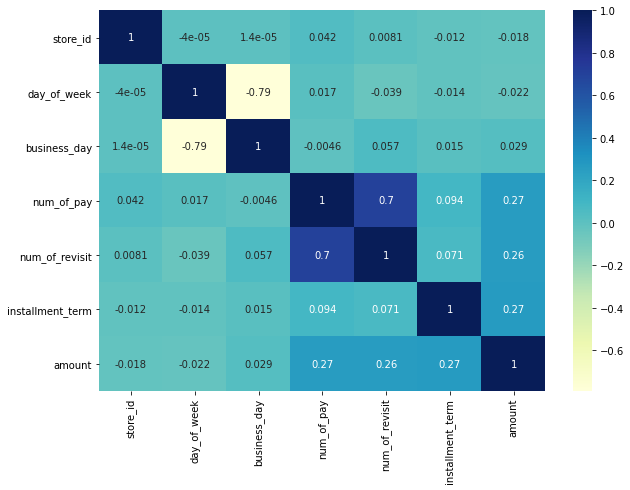

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.heatmap(daily_corr, annot=True, cmap='YlGnBu')

#### 모델링을 위해 월 단위로 resampling

In [ ]:
df_day.head(30)

store_id  day_of_week  business_day  num_of_pay  \
transacted_date                                                    
2016-06-01              0            2             1           4   
2016-06-02              0            3             1           7   
2016-06-03              0            4             1           3   
2016-06-04              0            5             0           7   
2016-06-05              0            6             0           3   
2016-06-06              0            0             1           4   
2016-06-07              0            1             1           0   
2016-06-08              0            2             1           0   
2016-06-09              0            3             1           9   
2016-06-10              0            4             1           8   
2016-06-11              0            5             0           9   
2016-06-12              0            6             0           4   
2016-06-13              0            0             1           8   
2016-06-14              0            1             1           0   
2016-06-15              0            2             1           5   
2016-06-16              0            3             1           4   
2016-06-17              0            4             1           5   
2016-06-18              0            5             0           6   
2016-06-19              0            6             0           5   
2016-06-20              0            0             1           8   
2016-06-21              0            1             1           0   
2016-06-22              0            2             1           6   
2016-06-23              0            3             1           4   
2016-06-24              0            4             1           6   
2016-06-25              0            5             0          10   
2016-06-26              0            6             0           3   
2016-06-27              0            0             1           5   
2016-06-28              0            1             1           0   
2016-06-29              0            2             1          10   
2016-06-30              0            3             1           2   

                 num_of_revisit  installment_term region type_of_business  \
transacted_date                                                             
2016-06-01              4.00000                 0    NaN           기타 미용업   
2016-06-02              3.00000                 0    NaN           기타 미용업   
2016-06-03              2.00000                 0    NaN           기타 미용업   
2016-06-04              3.00000                 0    NaN           기타 미용업   
2016-06-05              3.00000                 0    NaN           기타 미용업   
2016-06-06              2.00000                 0    NaN           기타 미용업   
2016-06-07              0.00000                 0    NaN           기타 미용업   
2016-06-08              0.00000                 0    NaN           기타 미용업   
2016-06-09              5.00000                 0    NaN           기타 미용업   
2016-06-10              4.00000                 8    NaN           기타 미용업   
2016-06-11              6.00000                 0    NaN           기타 미용업   
2016-06-12              1.00000                 0    NaN           기타 미용업   
2016-06-13              5.00000                 0    NaN           기타 미용업   
2016-06-14              0.00000                 0    NaN           기타 미용업   
2016-06-15              3.00000                 0    NaN           기타 미용업   
2016-06-16              2.00000                 0    NaN           기타 미용업   
2016-06-17              3.00000                 0    NaN           기타 미용업   
2016-06-18              3.00000                 0    NaN           기타 미용업   
2016-06-19              2.00000                 2    NaN           기타 미용업   
2016-06-20              3.00000                 0    NaN           기타 미용업   
2016-06-21              0.00000                 0    NaN           기타 미용업   
2016-06-22              1.00000                 0    NaN           기타

In [ ]:
def resample_month(frame_day):
    sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']

    df_monthly = pd.DataFrame()

    for i in frame_day.store_id.unique():
        df_set = frame_day[frame_day['store_id'] == i]
        
        # 결측값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        # date_range 함수를 이용하면 start와 end 날짜 사이의 모든 날짜를 담은 변수를 생성할 수 있음
        # concat 함수로 이전 이후 한 달 row를 추가로 붙임
        prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), 
                                  end=(df_set.index[0] - relativedelta(months=1)))
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), 
                                 end=(df_set.index[-1] + relativedelta(months=1)))
        df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)
        
        # strftime 함수는 datetime 형식의 모양을 변경해주는 것 (연-월 단위)
        # 첫 달과 마지막 달에 1을 넣어둠
        df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
        df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1
        
        # 매출액이 0이 아닌 데이터에 대해 요일 카운트와 business day합을 넣음
        tot_day = df_set[df_set.amount != 0]['day_of_week'].resample(rule='m').count().rename('real_tot_day')
        business = df_set[df_set.amount != 0]['business_day'].resample(rule='m').sum().rename('real_business_day')
        
        # 이전 이후 달 삭제(drop 함수 이용해 인덱스 기준으로 삭제)
        business = business.drop([business.index[0], business.index[-1]], axis=0)
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)
        
        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)

        df.insert(0, 'store_id', i)
        df.insert(6, 'region', df_set['region'].values[0])
        df.insert(7, 'type_of_business', df_set['type_of_business'].values[0])

        df_monthly = pd.concat([df_monthly, df], axis=0)
   
    return df_monthly

In [ ]:
%%time
df_month = resample_month(df_day)

CPU times: user 1min 16s, sys: 231 ms, total: 1min 16s
Wall time: 1min 16s


In [ ]:
df_month.isnull().sum()

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [ ]:
# 전체 row 개수 대비 컬럼별 결측값 row 개수 비율 확인
print("rate of 'region' :" , df_month.region.isnull().sum() / len(df_month))
print("rate of 'type_of_business' :" , df_month.type_of_business.isnull().sum() / len(df_month))

rate of 'region' : 0.34310104243618156
rate of 'type_of_business' : 0.5917754247722236


각각 34%. 56%에 이르는 null값을 채우는 것은 너무 어렵고, 채워도 오차가 클 것으로 예상하여 `region`과 `type_of_business` 삭제

In [ ]:
df_month = df_month.drop(['region', 'type_of_business'], axis=1)
df_month.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

In [ ]:
df_month.to_csv('monthly-processed.csv')

In [ ]:
df_month = pd.read_csv('/content/monthly-processed.csv')
df_month.head()

Unnamed: 0  store_id  real_tot_day  real_business_day  num_of_pay  \
0  2016-06-30         0            25           17.00000   145.00000   
1  2016-07-31         0            26           16.00000   178.00000   
2  2016-08-31         0            24           16.00000   171.00000   
3  2016-09-30         0            25           19.00000   160.00000   
4  2016-10-31         0            26           16.00000   167.00000   

   num_of_revisit  installment_term        amount  
0        77.00000          13.00000  747000.00000  
1       105.00000          24.00000 1005000.00000  
2        97.00000          69.00000  871571.42857  
3       103.00000          15.00000  897857.14286  
4       115.00000           9.00000  835428.57143

In [ ]:
df_month.rename(columns={'Unnamed: 0' : 'transacted_date'}, inplace=True)
df_month['transacted_date'] = pd.to_datetime(df_month['transacted_date'])
df_month = df_month.set_index('transacted_date')

In [ ]:
print(df_month.shape)
df_month.head()

(60915, 7)


store_id  real_tot_day  real_business_day  num_of_pay  \
transacted_date                                                          
2016-06-30              0            25           17.00000   145.00000   
2016-07-31              0            26           16.00000   178.00000   
2016-08-31              0            24           16.00000   171.00000   
2016-09-30              0            25           19.00000   160.00000   
2016-10-31              0            26           16.00000   167.00000   

                 num_of_revisit  installment_term        amount  
transacted_date                                                  
2016-06-30             77.00000          13.00000  747000.00000  
2016-07-31            105.00000          24.00000 1005000.00000  
2016-08-31             97.00000          69.00000  871571.42857  
2016-09-30            103.00000          15.00000  897857.14286  
2016-10-31            115.00000           9.00000  835428.57143

---

### Step 2. EDA

#### 변수의 describe 확인

In [ ]:
df_month.describe()

store_id  real_tot_day  real_business_day  num_of_pay  \
count 60915.00000   60915.00000        60915.00000 60915.00000   
mean   1050.48428      21.06987           15.89640   107.63544   
std     617.48320       7.75327            5.63136   101.24413   
min       0.00000       0.00000            0.00000     0.00000   
25%     515.00000      16.00000           12.00000    32.00000   
50%    1039.00000      23.00000           17.00000    73.00000   
75%    1587.00000      28.00000           21.00000   159.00000   
max    2136.00000      31.00000           23.00000  2186.00000   

       num_of_revisit  installment_term         amount  
count     60915.00000       60915.00000    60915.00000  
mean         40.01136          14.87540  1123187.83063  
std          43.88133          33.42161  1753567.15171  
min           0.00000           0.00000  -514285.71429  
25%          11.00000           0.00000   339642.85714  
50%          26.00000           3.00000   710714.28571  
75%          54.00000          14.00000  1344650.00000  
max        2154.00000        1125.00000 61429316.14286

#### target 변수의 정규성 확인

Skewness : 0.48245510908400707


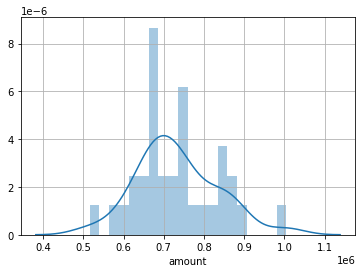

Skewness : 0.510252105069473


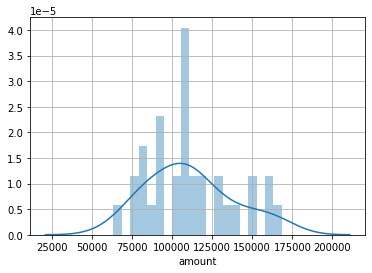

Skewness : 0.9982599271676977


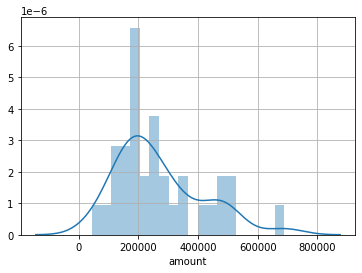

In [ ]:
for i in df_month['store_id'].unique()[:3]:
  print('Skewness :', df_month[df_month['store_id'] == i]['amount'].skew())
  sns.distplot(df_month[df_month['store_id'] == i].amount, bins=20)
  plt.grid()
  plt.show()

log scale : -0.5308009496851174


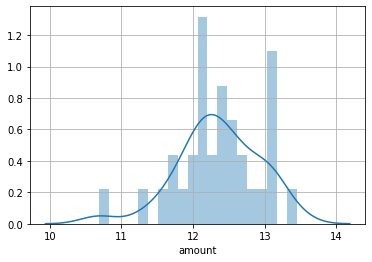

log scale : -0.5308009496851174


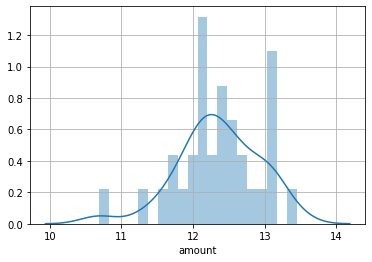

log scale : -0.5308009496851174


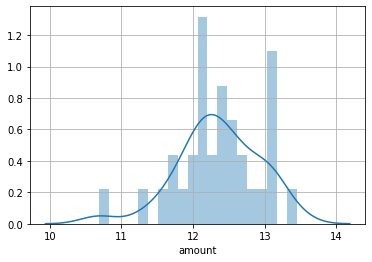

In [ ]:
for i in df_month['store_id'].unique()[:3]:
    print('log scale :', np.log(df_month[df_month.store_id == 2].amount).skew())
    sns.distplot(np.log(df_month[df_month.store_id == 2].amount), bins=20)
    plt.grid()
    plt.show()

#### 변수 별 분포 시각화

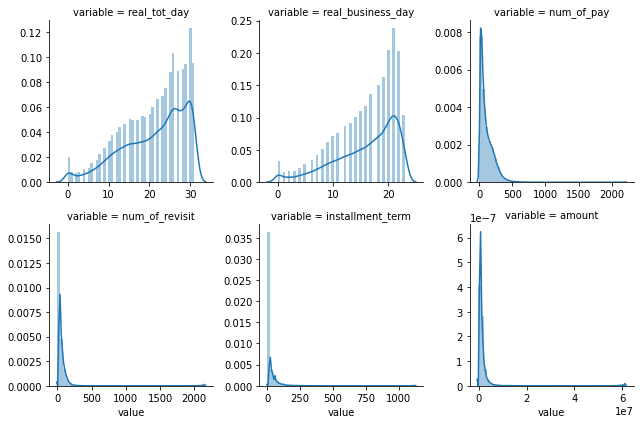

In [ ]:
# melt 함수를 이용해 컬럼을 row 단위로 변경해줌
# 상점 id 빼고 전부 melt
# melt하면 컬럼 6개 variable이라는 컬럼의 값으로 들어가고, 각 컬럼의 값들은 value라는 컬럼의 값으로 들어감

f = pd.melt(df_month, value_vars=df_month.columns[1:])
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')
plt.show()

#### 같은 기간 동안 여러 상점 매출의 추이 및 스케일 확인 (첫 7개 상점)

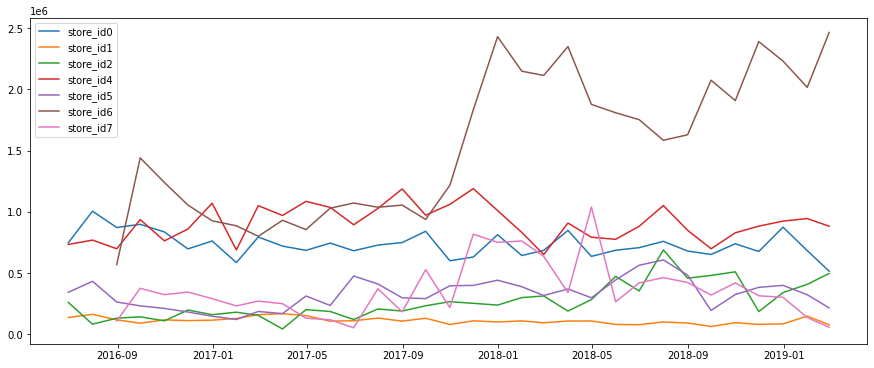

In [ ]:
plt.figure(figsize=(15, 6))
for i in df_month.store_id.unique()[:7]:
  plt.plot(df_month[df_month['store_id'] == i].index,
           df_month[df_month['store_id'] == i].amount,
           label = 'store_id{}'.format(i))
plt.legend()

각 `store_id`별로 다른 trend와 seasonality, scale을 가지는 것을 확인

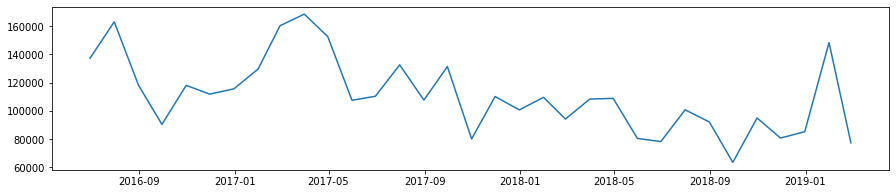

In [ ]:
plt.figure(figsize=(15, 3))
plt.plot(df_month[df_month.store_id == 1].index,
         df_month[df_month.store_id == 1].amount)

#### 다른 변수들이 'amount'와 같은 패턴을 보이는 지 확인

In [ ]:
def plot_model_graph(data_frame, store_num, idx_col, y_cols):
    df_set = data_frame[data_frame['store_id'] == store_num]
    
    fig, ax1 = plt.subplots(figsize=(15, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.index, df_set[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.index, df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))

    fig.tight_layout()
    plt.show()

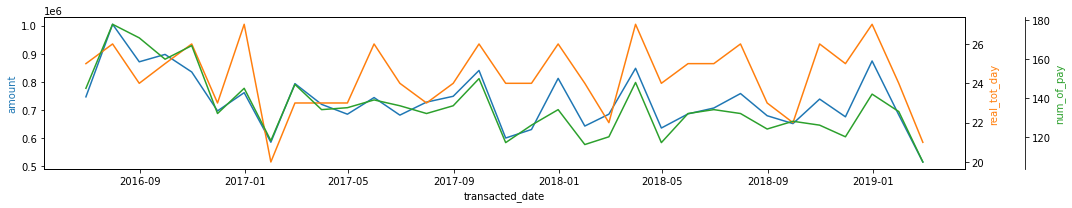

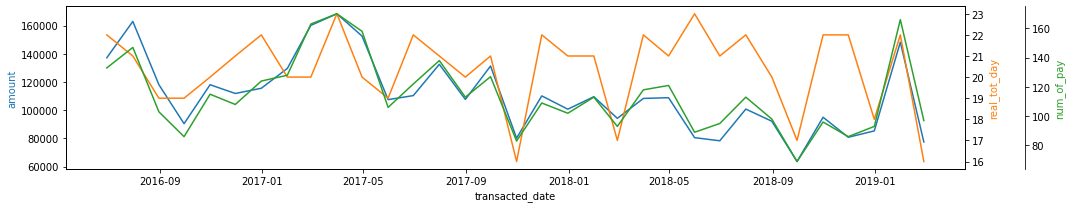

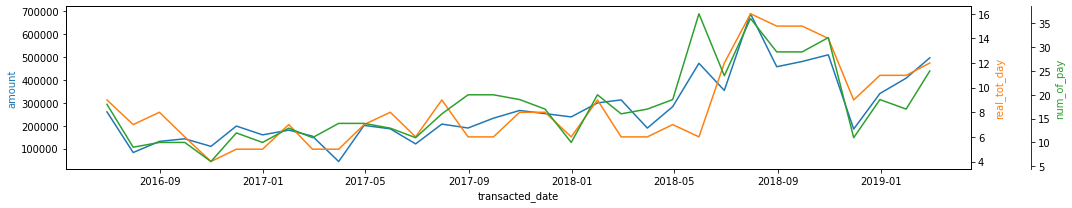

In [ ]:
# 상점 id별로 매출액, 총 영업일, 결제 횟수 비교
for i in df_month.store_id.unique()[:3]:
  plot_model_graph(df_month, i, 'transacted_date', ['amount', 'real_tot_day', 'num_of_pay'])

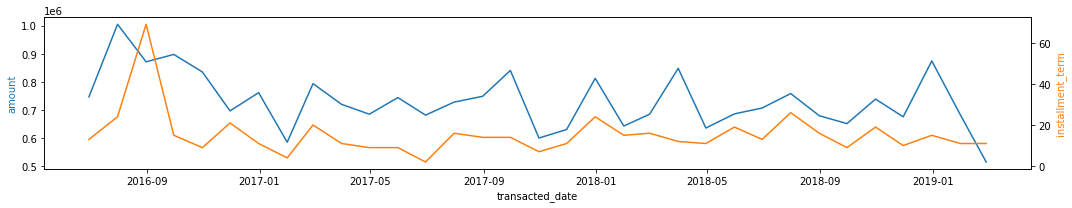

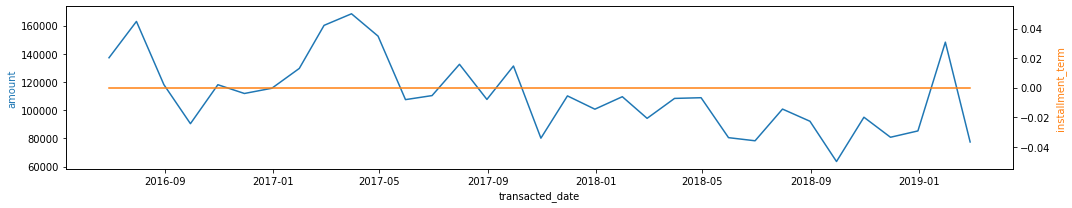

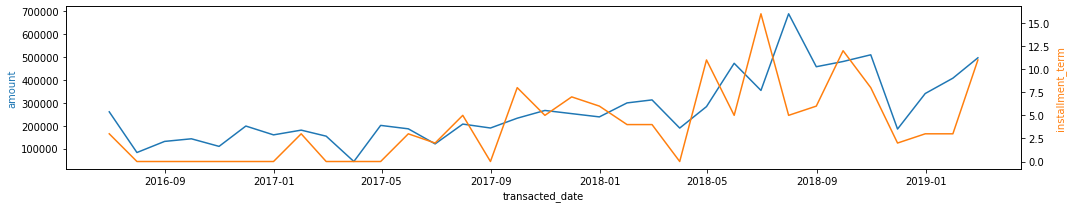

In [ ]:
# 상점 id별로 매출액, 할부개월수 비교
for i in df_month.store_id.unique()[:3]:
  plot_model_graph(df_month, i, 'transacted_date', ['amount', 'installment_term'])

### Step 3. Modeling - Time Series

#### Simple Moving Average - 단순이동평균

- 단순이동평균은 특정 기간 동안의 data를 단순 평균하여 계산한다. 따라서 그 기간 동안의 data를 대표하는 값이 이동평균 안에서 그 동안의 data 움직임을 포함하고 있다.

- 이동평균의 특징인 지연(lag)이 발생하며 수학적으로는 n/2 시간 만큼의 지역이 발생한다.

- 단순이동평균은 모든 데이터의 중요도를 동일하다고 간주한다.


$$SMA_{t}= \frac{D_{t−(n−1)}+D_{t−(n−2)}+⋯+D_{t−1}+D_{t}}{n}$$
<script type="text/javascript" src="https://www.hostmath.com/Math/MathJax.js?config=OK"></script>

In [ ]:
def make_sma_arr(window_num):
  ma_arr = np.array([])
  for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    ma_arr = np.concatenate((ma_arr, df_set.amount.rolling(window=window_num).mean().values))
    #rolling : 이동평균 계산 (window 몇개씩 연산할지 입력, mean 평균)

  return ma_arr

In [ ]:
sma_month = df_month.copy()

sma_month.insert(7, 'amount_2ma', make_sma_arr(2))
sma_month.insert(8, 'amount_3ma', make_sma_arr(3))
sma_month.insert(9, 'amount_6ma', make_sma_arr(6))

In [ ]:
sma_month.head(7)

store_id  real_tot_day  real_business_day  num_of_pay  \
transacted_date                                                          
2016-06-30              0            25           17.00000   145.00000   
2016-07-31              0            26           16.00000   178.00000   
2016-08-31              0            24           16.00000   171.00000   
2016-09-30              0            25           19.00000   160.00000   
2016-10-31              0            26           16.00000   167.00000   
2016-11-30              0            23           15.00000   132.00000   
2016-12-31              0            27           18.00000   145.00000   

                 num_of_revisit  installment_term        amount   amount_2ma  \
transacted_date                                                                
2016-06-30             77.00000          13.00000  747000.00000          nan   
2016-07-31            105.00000          24.00000 1005000.00000 876000.00000   
2016-08-31             97.00000          69.00000  871571.42857 938285.71429   
2016-09-30            103.00000          15.00000  897857.14286 884714.28571   
2016-10-31            115.00000           9.00000  835428.57143 866642.85714   
2016-11-30             93.00000          21.00000  697000.00000 766214.28571   
2016-12-31            103.00000          11.00000  761857.14286 729428.57143   

                  amount_3ma   amount_6ma  
transacted_date                            
2016-06-30               nan          nan  
2016-07-31               nan          nan  
2016-08-31      874523.80952          nan  
2016-09-30      924809.52381          nan  
2016-10-31      868285.71429          nan  
2016-11-30      810095.23810 842309.52381  
2016-12-31      764761.90476 844785.71429

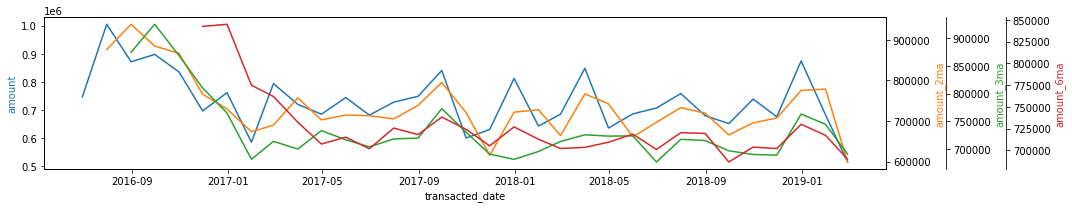

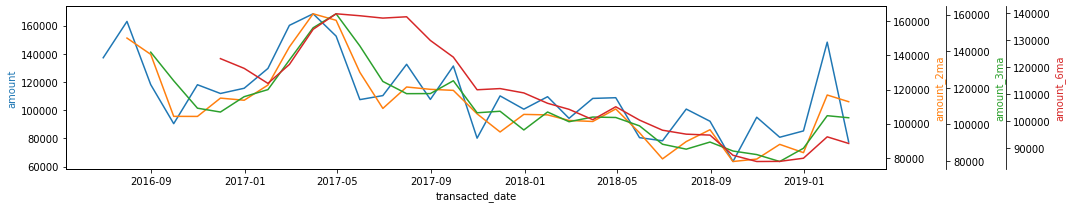

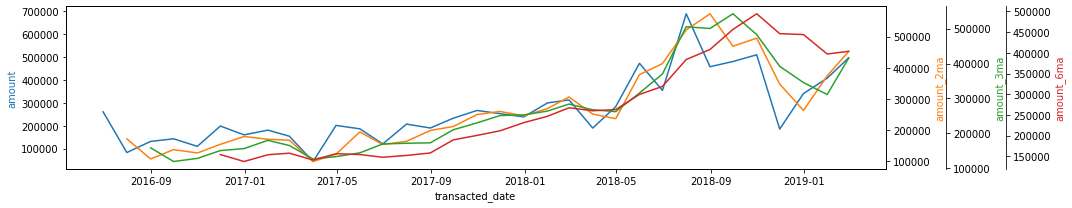

In [ ]:
for i in sma_month.store_id.unique()[:3]:
  plot_model_graph(sma_month, i, 'transacted_date', ['amount', 'amount_2ma', 'amount_3ma', 'amount_6ma'])

In [ ]:
print("2 winodw SMA MAE Score : ", mae(sma_month.amount_2ma.fillna(0), sma_month.amount.values))
print("3 window SMA MAE Score : ", mae(sma_month.amount_3ma.fillna(0), sma_month.amount.values))
print("6 window SMA MAE Score : ", mae(sma_month.amount_6ma.fillna(0), sma_month.amount.values))

2 winodw SMA MAE Score :  180687.25906004856
3 window SMA MAE Score :  251607.45528312284
6 window SMA MAE Score :  387465.0993765708


rolling의 경우, window 3을 예를 들면, t시점에 대한 값으로 t시점, t-1시점, t-2시점의 평균을 사용한다. 

우리가 필요한 것은 t시점을 위해 t-1, t-2, t-3의 평균을 구하는 것이므로 함수를 생성하여 진행한다.

In [ ]:
def make_minus_rolling(data_frame, rolling_num):
    def minus_shift_rolling(df_num, num):
        a = np.average(df_num.values[-num:])
        b = np.average(np.append(df_set.values[-(num-1):], a))
        if num > 2:
            c = np.average(np.append(np.append(df_set.values[-(num-2):], a), b))
        else:
            c = np.average((a, b))
        return np.sum((a, b, c))

    minus_rolling_arr = np.array([])
    for i in data_frame.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        minus_rolling_arr = np.concatenate((minus_rolling_arr, np.array([minus_shift_rolling(df_set, rolling_num)])))
        
    df_rolling = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : minus_rolling_arr})
    
    return df_rolling

In [ ]:
for i in range(2, 5):
  df_rolling = make_minus_rolling(df_month, i)
  df_rolling.to_csv('/content/rolling_sub.csv'.format(i), index=False)

- Simple Moving Average(3 rolling) : 831,158.397180

---

#### Exponential Moving Average 지수이동평균

지수이동평균은 가중이동평균 중의 하나로 단순이동평균보다 최근의 데이터에 높은 가중치를 부여하는 방법이다.

$$EMA_{t}= D_{t}\times\frac{2}{N+1}+EMA_{t−1}\times(1-\frac{2}{N+1})$$
<script type="text/javascript" src="https://www.hostmath.com/Math/MathJax.js?config=OK"></script>

In [ ]:
def make_ewm_arr(data_frame, span_num):
  arr_ewm = np.array([])
  for i in data_frame.store_id.unique():
    df_set = data_frame[data_frame.store_id == i]
    # 여기에서 지정하는 span값은 위 수식에서 N에 해당한다
    arr_ewm = np.concatenate((arr_ewm, df_set.amount.ewm(span=span_num).mean().values))
  return arr_ewm

In [ ]:
ewm_month = df_month.copy()

ewm_month.insert(7, 'amount_3ewm', make_ewm_arr(df_month, 3))
ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(df_month, 6))

In [ ]:
ewm_month.head(3)

store_id  real_tot_day  real_business_day  num_of_pay  \
transacted_date                                                          
2016-06-30              0            25           17.00000   145.00000   
2016-07-31              0            26           16.00000   178.00000   
2016-08-31              0            24           16.00000   171.00000   

                 num_of_revisit  installment_term        amount  amount_3ewm  \
transacted_date                                                                
2016-06-30             77.00000          13.00000  747000.00000 747000.00000   
2016-07-31            105.00000          24.00000 1005000.00000 919000.00000   
2016-08-31             97.00000          69.00000  871571.42857 891897.95918   

                 amount_6ewm  
transacted_date               
2016-06-30      747000.00000  
2016-07-31      897500.00000  
2016-08-31      885844.03670

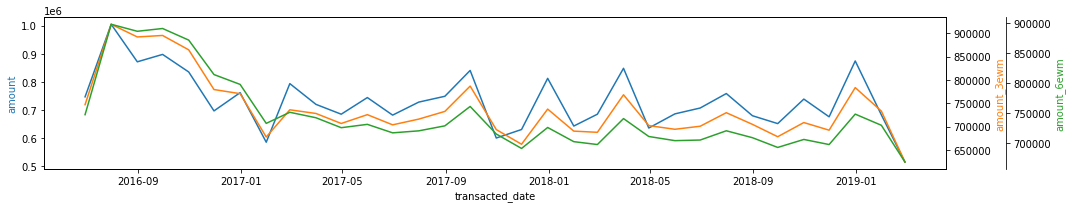

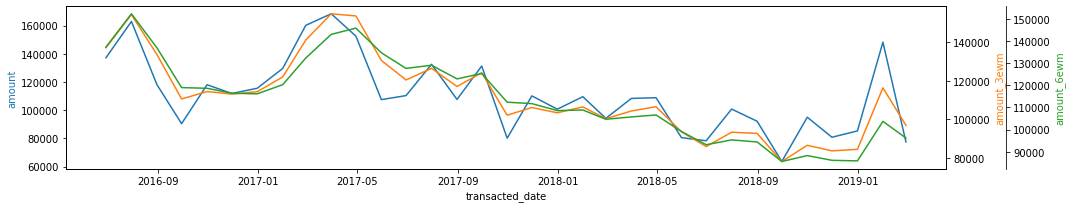

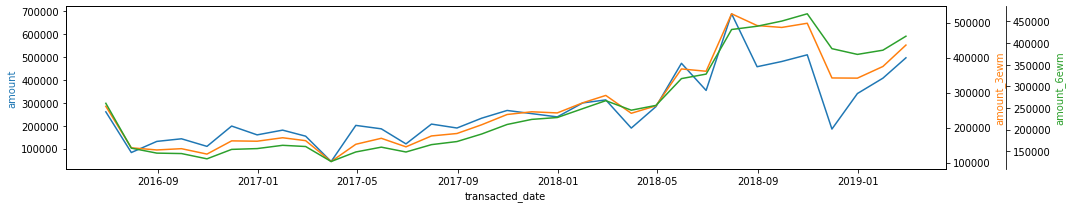

In [ ]:
for i in ewm_month.store_id.unique()[:3]:
    plot_model_graph(ewm_month, i, 'transacted_date', ['amount', 'amount_3ewm', 'amount_6ewm'])

In [ ]:
print("3 N EWM MAE Score : ", mae(ewm_month.amount_3ewm, sma_month.amount.values))
print("6 N EWM MAE Score : ", mae(ewm_month.amount_6ewm, sma_month.amount.values))

3 N EWM MAE Score :  134855.11946915495
6 N EWM MAE Score :  193447.63093078104


3~7 Exponential Weighted Moving Score 확인

In [ ]:
def make_wma_sub(data_frame, span_num):
  concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
  wma_sub = np.array([])

  for i in df_month.store_id.unique():
    df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
    wma_train = pd.concat([df_set, concat_3mon], axis=0)

    num_sub = np.array([wma_train.amount.ewm(span=span_num).mean()['2019-03':].sum()])
    wma_sub = np.concatenate((wma_sub, num_sub))
    
  df_wma_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : wma_sub})
  return df_wma_sub

In [ ]:
for i in range(2, 7):
  wma_sub = make_wma_sub(df_month, i)
  wma_sub.to_csv('/content/wma_sub.csv'.format(i), index=False)

- 2 span 제출 Score : 820102.106670
- 3 span 제출 Score : 785488.281930
- 4 span 제출 Score : 770667.895320
- 5 span 제출 Score : 767498.551420
- 6 span 제출 Score : 770414.027040

---

#### Exponential Smoothing 지수평활법 - Simple / Holt's / Holt-Winter's

**Simple Exponential Smoothing**

  - trend나 seasonality 반영을 하지 못함
  - level 정도만 수평선으로 나옴
  

$$F_{t} = F_{t-1} + \alpha(D_{t-1} - F_{t-1})$$
<script type="text/javascript" src="https://www.hostmath.com/Math/MathJax.js?config=OK"></script>

$$F_{t} = (1-\alpha)F_{t-1} + \alpha D_{t-1}$$
<script type="text/javascript" src="https://www.hostmath.com/Math/MathJax.js?config=OK"></script>

- Ft : 현재 시점의 예측 값
- F(t-1) : 이전 시점의 예측 값
- D(t-1) : 이전 시점의 실제 값
- \alpha : smoothing 요소, 0< \alpha <1

In [ ]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

ses_model = SimpleExpSmoothing(train.amount)
ses_result = ses_model.fit()
ses_pred = ses_result.forecast(len(test))

In [ ]:
print("store_id 0 mean value: ", df_set.amount.mean())
print("MAE Score of test : ", mae(test.amount, ses_pred))

store_id 0 mean value:  732559.7402597402
MAE Score of test :  78218.11194659187


In [ ]:
def plot_train_test_pred_graph(trainset, testset, pred):
  plt.figure(figsize=(15, 3))
  plt.plot(trainset.amount, label='train')
  plt.plot(testset.amount, label='test')
  plt.plot(testset.index, pred, label='prediction')
  plt.legend()
  plt.show()

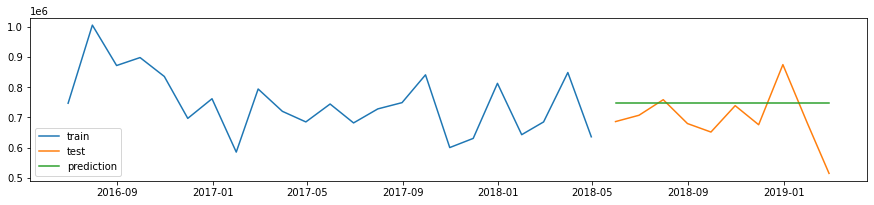

In [ ]:
plot_train_test_pred_graph(train, test, ses_pred)

In [ ]:
ses_pred_arr = np.array([])
for i in df_month.store_id.unique():
  df_set = df_month[df_month.store_id == i]

  ses_model = SimpleExpSmoothing(df_set.amount)
  ses_result = ses_model.fit()
  ses_pred = ses_result.forecast(3)

  ses_pred_arr = np.concatenate((ses_pred_arr, np.array([ses_pred.sum()])))

In [ ]:
df_ses_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : ses_pred_arr})

- Simple Exponential Smoothing Score : 818205.82245

**Holt's Exponential Smoothing**

- trend로 데이터를 예측하기 위해 simple exponential smoothing에서 확장한 것

- 예측을 위한 식 외에 level smoothing을 위한 식과 trend smoothing을 위한 식 포함됨

- 생성된 예측은 선형적으로 나타나기 때문에 예측 범위가 멀어질 수록 over-forecast되는 경향 있음

In [ ]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

holt_model = Holt(np.array(train.amount))
holt_result = holt_model.fit()
holt_pred = holt_result.forecast(len(test))

Mean value of store_id 0 :  732559.7402597402
MAE Score of test : 104762.75933861124


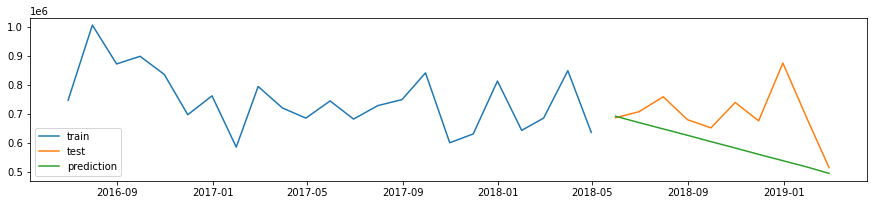

In [ ]:
print("Mean value of store_id 0 : ", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, holt_pred))

plot_train_test_pred_graph(train, test, holt_pred)

In [ ]:
%%time
holt_pred_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    
    holt_model = Holt(np.array(df_set.amount))
    holt_result = holt_model.fit()
    holt_pred = holt_result.forecast(3)
    
    holt_pred_arr = np.concatenate((holt_pred_arr, np.array([holt_pred.sum()])))

CPU times: user 19.4 s, sys: 8.23 ms, total: 19.4 s
Wall time: 19.4 s


In [ ]:
holt_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : holt_pred_arr})

- Holt's Exponential Smoothing Score : 926470.756080

**Holt-Winter's Exponential Smoothing**

Holt 방식에서 seasonality를 반영하여 확장한 방법

In [ ]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

# 최적값을 찾기 위한 기준
es_score = 1000000000
best_period = 0

# 각 store_id의 최적의 seasonal period를 찾기 위한 탐색
for p in range(2, (len(train)//2) + 1):
  try:
    es_model = ExponentialSmoothing(np.array(train.amount), seasonal_periods=p,
                                    trend='add', seasonal='add')
    es_result = es_model.fit()
    es_pred = es_result.forecast(len(test))

    if es_score > mae(test.amout, es_pred):
      es_score = mae(test.amount, es_pred)
      best_period = p
  except:
    continue

Mean value of store_id 0 : 732559.7402597402
MAE Score of test : 1000000000
Best seasonal period : 0


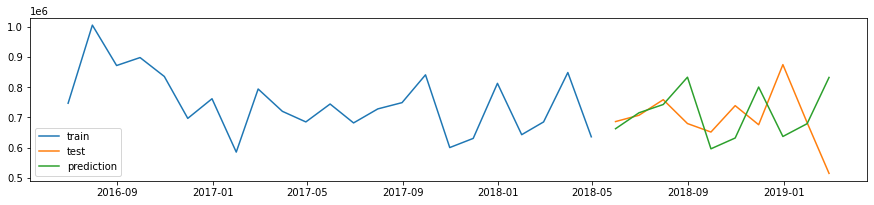

In [ ]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", es_score)
print("Best seasonal period :", best_period)

plot_train_test_pred_graph(train, test, es_pred)

In [ ]:
%%time
holt_winters_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]

    size = int(len(df_set) * 0.7)
    train = df_set[:size]
    test = df_set[size:]
    
    # 최적값을 찾기 위한 기준
    es_score = 1000000000
    best_period = 0
    # 각 store_id 최적의 seasonal period를 찾기 위한 탐색
    for p in range(2,(len(train)//2) + 1):
        try:
            es_model = ExponentialSmoothing(np.array(train.amount),seasonal_periods=p, trend='add', seasonal='add')
            es_result = es_model.fit()
            es_pred = es_result.forecast(len(test))

            if es_score > mae(test.amount, es_pred):
                es_score = mae(test.amount, es_pred)
                best_period = p
        except:
            continue
    
    # 최적의 parameter을 이용한 3개월 예측과 sum
    set_es_model = ExponentialSmoothing(np.array(df_set.amount), seasonal_periods=best_period, trend='add', seasonal='add')
    set_es_result = set_es_model.fit()
    set_es_pred = set_es_result.forecast(3)
    
    holt_winters_arr = np.concatenate((holt_winters_arr, np.array([set_es_pred.sum()])))

CPU times: user 18min 40s, sys: 1.63 s, total: 18min 42s
Wall time: 18min 40s


In [ ]:
holt_winters_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : holt_winters_arr})
holt_winters_sub.to_csv('/content/funda_holt_winters_sub.csv', index=False)

- Holt-Winter's Exponential Smoothing Score : 962259.599880

---

#### ARMA

- ARMA 모형은 AR(p) 모형과 MA(q) 모형의 특징을 모두 가지는 모형이다. 즉, p개의 자기 자신의 과거값과 q개의 과거 백색 잡음의 선형 조합으로 현재의 값이 정해지는 모형이다.

- 많은 `store_id`들이 AR의 정상상태 (stationary) 조건에 맞지 않아 1 이상의 p값을 적용할 수 없다.

  > 따라서 차분(difference)를 이용해 비정상상태(non-stationary)의 설명이 가능한 ARIMA를 추가로 진행한다.

In [ ]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

set_arma = statsmodels.tsa.arima_model.ARMA(train.amount, (0, 2))
set_result = set_arma.fit()

set_output = set_result.forecast(len(test))
set_pred = set_output[0]

Mean value of store_id 0 : 732559.7402597402
MAE Score of test : 80938.78193554627


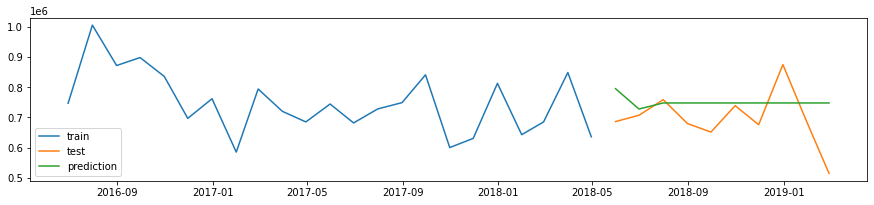

In [ ]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, set_pred))

plot_train_test_pred_graph(train, test, set_pred)

In [ ]:
%%time
arma_arr = np.array([])
for i in df_month.store_id.unique():
  df_set = df_month[df_month.store_id == i]

  # (0,2) 모델로 진행을 하다 error가 발생하면 (0, 1)
  try:
    arma_model = statsmodels.tsa.arima_model.ARMA(df_set.amount, (0,2))
    arma_result = arma_model.fit()
  except:
    arma_model = statsmodels.tsa.arima_model.ARMA(df_set.amount, (0,1))
    arma_result = arma_model.fit()
  
  output = arma_result.forecast(3)
  arma_arr = np.concatenate((arma_arr, np.array([output[0].sum()])))

CPU times: user 1min 17s, sys: 59.2 ms, total: 1min 17s
Wall time: 1min 17s


In [ ]:
df_arma_02_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount':arma_arr})
# (0, 2)로 진행했지만 nan값이 발생하는 경우 확인
df_null = df_arma_02_sub[df_arma_02_sub.amount.isnull()]
# nan값이 발생한 store_id는 (0,1) 모델로 재진행
for i in df_null.store_id:
  df_set = df_month[df_month.store_id == i]

  arma_model = statsmodels.tsa.arima_model.ARMA(df_set.amount, (0,1))
  arma_result = arma_model.fit()

  output = arma_result.forecast(3)

  idx_num = df_arma_02_sub[df_arma_02_sub.store_id == i].index.values[0]
  df_arma_02_sub[idx_num:idx_num + 1] = output[0].sum()

In [ ]:
df_arma_02_sub.to_csv('/content/funda_adj_arma_0_2_sub.csv', index=False)

- ARMA Score : 984368.752690

---

#### ARIMA(Autoregressive Integrated Moving Average)

- ARIMA 모델은 Y를 차분한 결과로 만들어지며 차분한 시계열이 ARMA 모형을 따르면 원래의 시계열 Y_t를 ARIMA 모형이라고 한다.

- 만약 d번 차분한 후에야 시계열 Y_t가 ARIMA(p, q) 모형을 따른다면 적분 차수가(order of integration)가 d인 ARIMA 모형으로 ARIMA(p, d, q)로 표기한다.

- q=0인 경우에는 ARI(p,d), q=0인 경우에는 IMA(d,q)로 표기한다.

- p, d, q의 조합을 탐색하며 최적 parameter를 찾고 기준은 fit에 저장되어 있는 AIC을 기준으로 한다. 다음과 같은 식을 가지며 작을 수록 좋은 모형이다.

In [ ]:
p = list(range(0, 6))
d = [0, 1, 2]
q = list(range(0, 6))

pdq = list(itertools.product(p, d, q))

In [ ]:
%%time
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

best_score = 10000000
best_param = 0
for param in pdq:
    try:
        arima_model = ARIMA(train.amount.values, order=param)
        result = arima_model.fit()
        if result.aic < best_score:
            best_score = result.aic
            best_param = param
    except:
        continue
        
set_arima = ARIMA(df_set.amount.values, order=best_param)
set_result = set_arima.fit()
set_pred = set_result.forecast(len(test))[0]

CPU times: user 9.14 s, sys: 836 ms, total: 9.97 s
Wall time: 8.97 s


Mean value of store_id 0 : 732559.7402597402
AIC Score of test : 557.6623843461919
Best parameter of (p, d, q):  (2, 2, 1)


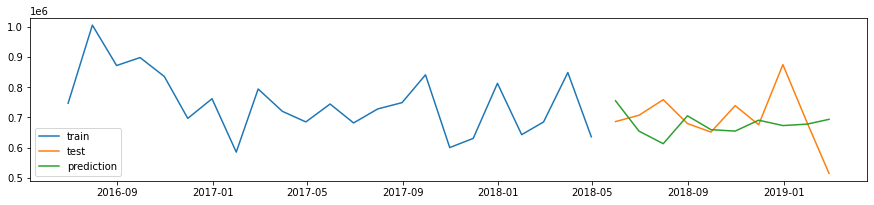

In [ ]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("AIC Score of test :", best_score)
print("Best parameter of (p, d, q): ",best_param)

plot_train_test_pred_graph(train, test, set_pred)

In [ ]:
%%time
arima_pred_arr = np.array([])
for i in df_month.store_id.unique()[:10]:
    df_set = df_month[df_month.store_id == i]

    best_score = 10000000000
    best_param = 0
    for param in pdq:
        try:
            arima_model = ARIMA(df_set.amount.values, order=param)
            result = arima_model.fit()
            # 최적 parameter는 fit에 저장되어 있는 AIC값을 기준으로 선정 한다.
            if result.aic < best_score:
                best_score = result.aic
                best_param = param
        except:
            continue

    
    arima_model = ARIMA(df_set.amount.values, order=best_param)
    arima_result = arima_model.fit()
    arima_pred = arima_result.forecast(3)[0]

    arima_pred_arr = np.concatenate((arima_pred_arr, np.array([arima_pred.sum()])))

CPU times: user 4min 11s, sys: 30.6 s, total: 4min 41s
Wall time: 4min 5s


- ARIMA MAE Score : 1080182.482790

---

#### Facebook Prophet

- prophet은 페이스북에서 개발한 시계열 예측 패키지이다. ARIMA와 같이 확률론적이고 이론적인 모형이 아닌 몇가지 경험적 규칙 (heuristic rule)을 사용하는 단순 회귀 모형이지만 단기적 예측에서는 큰 문제 없이 사용할 수 있다.

- prophet은 다음 순서로 시계열에 대한 회귀분석 모형을 만든다.
  - 시간 데이터의 각종 특징을 임베딩하여 계절성 추정을 한다.
  - 나머지 데이터는 구간별 선형회귀(piecewise linear regression) 분석을 한다. 구간 구분점을 change point라고 한다.

- prophet을 사용하기 위해서는 ds, y 2개의 column만을 정의하여 사용해야 한다.

- prophet은 Growth, Seasonality, Holidays로 구성되어 있다.

In [ ]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

In [ ]:
# prophet은 ds와 y 두 개의 column으로만 진행
df_prophet = pd.DataFrame({'ds' : train.index, 'y' : train.amount}).reset_index(drop=True) 

prophet_model = Prophet() # 예측값에 상한과 하한을 두지 않을 것이기 때문에 'logistic' 등을 사용하지 않고 default인 'linear' 사용
result = prophet_model.fit(df_prophet)

prophet_test = pd.DataFrame(test.index).rename(columns={'transacted_date' : 'ds'})
prophet_pred_df = result.predict(prophet_test)
prophet_pred = prophet_pred_df.yhat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


Mean value of store_id 0 : 732559.7402597402
MAE Score of test : 80553.73059130748


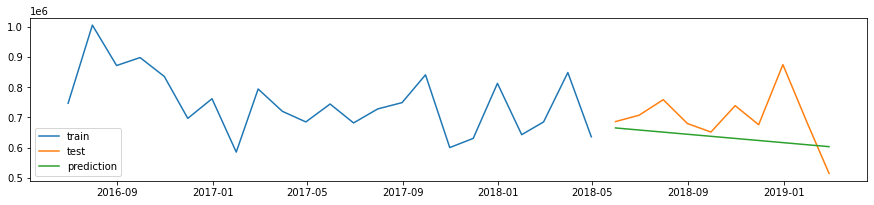

In [ ]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, prophet_pred))

plot_train_test_pred_graph(train, test, prophet_pred)

In [ ]:
%%time
front_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    # 각 store_id를 prophet에 맞는 dataframe의 형태로 생성('ds', 'y' columns)
    df_prophet = pd.DataFrame({'ds' : df_set.index, 'y' : df_set.amount}).reset_index(drop=True)
    
    # 예측값에 상한과 하한을 두지 않을 것이기 때문에 'logistic' growth를 사용하지 않고 default인 'linear' growth 사용
    prophet_model = Prophet() 
    result = prophet_model.fit(df_prophet)

    # 예측할 date를 prophet 예측에 맞는 dataframe 형태로 생성
    extend_date = pd.date_range(start=df_set.index[-1], end=dt.strptime('2019-05-31', "%Y-%m-%d"), freq='m')[1:]
    extend_future = pd.DataFrame(extend_date).rename(columns = {0 : 'ds'})
    forecast = result.predict(extend_future)
    
    front_arr = np.concatenate((front_arr, np.array([forecast.yhat[:3].sum()])))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

CPU times: user 1h 14min 58s, sys: 1min 42s, total: 1h 16min 40s
Wall time: 1h 16min 44s


In [ ]:
df_prophet_front_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : front_arr})
df_prophet_front_sub.to_csv('/content/funda_prophet_front_sub.csv', index=False)

---

#### Time-Series Model 최종 Score

- Simple Moving Average(3 rolling) : 831,158.397180
- **Exponential Moving Average(5 span) : 767,498.551420**
- Simple Exponential Smoothing : 818,205.822450
- Holt's Exponential Smoothing : 926,470.756080
- Holt-Winter's Exponential Smoothing : 962,259.599880
- ARMA model : 984,368.752690
- ARIMA model : 1,080,182.482790
- Facebook prophet : 1,221,173.032530

Time Series Model의 경우, Exponential Moving Average의 결과가 가장 좋았다.

상대적으로 단순한 모형들의 점수가 좋았다. 뚜렷한 trend나 seasonality가 없거나 data의 수가 적어서 파악하기 힘든데 trend나 seasonality를 적용하는 복잡한 모형들을 사용해서인 것으로 추측된다.

---

### [번외] 시계열 데이터 요소분해와 정상화

In [ ]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

- 자기상관함수 (ACF, AutoCovariance Function) : 동일한 변수를 시점을 달리해 관찰했을 때 시점에 따라 자료 간 상호 연관관계를 나타내는 척도 (Time별 & Time Lag별 데이터의 유사성 검토)

- 부분자기상관함수 (PACF, Partial ACF) : 두 변수를 제외한 모든 변수의 영향을 제거하고, 두 변수 사이의 순수한 상호 연관관계를 나타내는 척도

  > 정상성을 띄는 자료의 경우 ACF와 PACF 모두 각 시차에서 신뢰한계(보통 표준편차의 2배) 범위 내에 존재 

<Figure size 2160x7200 with 0 Axes>

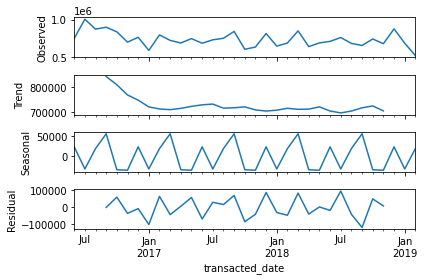

In [ ]:
# 분해 작업 진행
decomposition = seasonal_decompose(df_month[df_month['store_id'] == 0]['amount'], freq=6)
fig = plt.figure(figsize=(30, 100))
fig = decomposition.plot()

<Figure size 2160x7200 with 0 Axes>

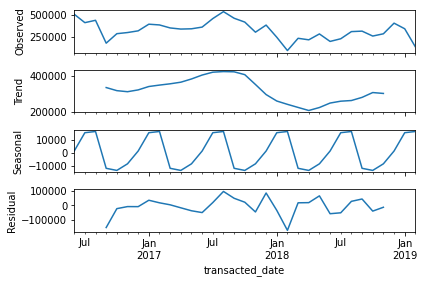

In [ ]:
decomposition = seasonal_decompose(df_month[df_month['store_id'] == 30]['amount'], freq=6)
fig = plt.figure(figsize=(30, 100))
fig = decomposition.plot()

<Figure size 2160x7200 with 0 Axes>

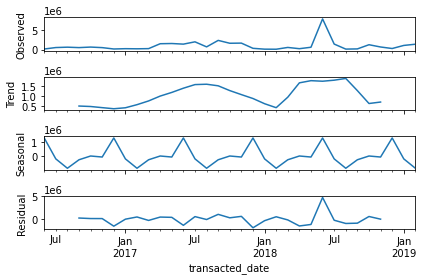

In [ ]:
decomposition = seasonal_decompose(df_month[df_month['store_id'] == 540]['amount'], freq=6)
fig = plt.figure(figsize=(30, 100))
fig = decomposition.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

  # determing rolling statistics
  rolmean = timeseries.rolling(12).mean()
  rolstd = timeseries.rolling(12).std()

  # plot rolling statistics
  fig = plt.figure(figsize=(10, 6))
  orig = plt.plot(timeseries, color = 'blue', label = 'Original')
  mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
  std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')

  plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
  plt.show()

  # perform dickey-fuller test:
  print('<Results of Dickey-Fuller Test>')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4],
                       index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
  print(dfoutput)

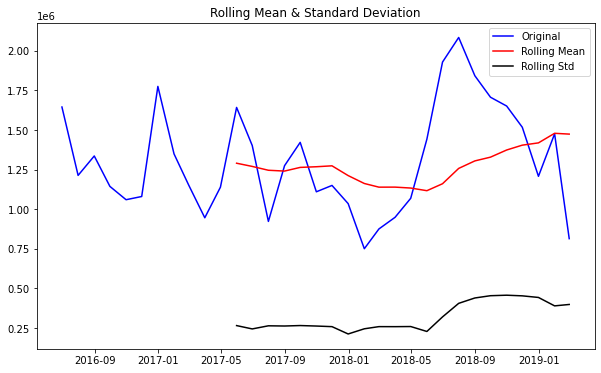

<Results of Dickey-Fuller Test>
Test Statistic                -2.75993
p-value                        0.06423
#Lags Used                     0.00000
Number of Observations Used   32.00000
Critical Value (1%)           -3.65352
Critical Value (5%)           -2.95722
Critical Value (10%)          -2.61759
dtype: float64


In [ ]:
test_stationarity(df_month[df_month['store_id']==50]['amount'])

- p값이 0.06으로 non-stationary로 판단할 수 있음
- 따라서 정상화가 필요
- 아래는 1개월 차분으로 추세 파악과 12개월 차분으로 seasonality 제거한 모습

In [ ]:
df_temp = df_month[df_month.store_id==50]

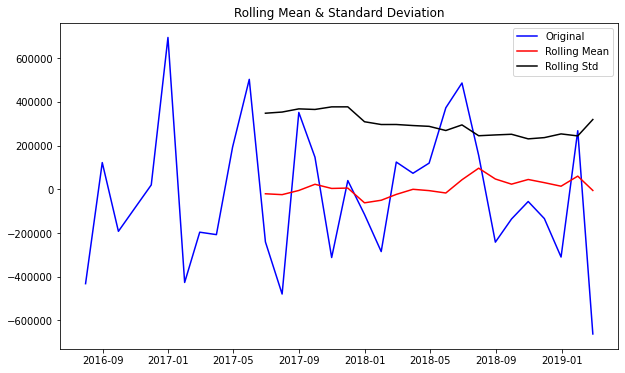

<Results of Dickey-Fuller Test>
Test Statistic                -5.64673
p-value                        0.00000
#Lags Used                     0.00000
Number of Observations Used   31.00000
Critical Value (1%)           -3.66143
Critical Value (5%)           -2.96053
Critical Value (10%)          -2.61932
dtype: float64


In [ ]:
df_temp['first_difference'] = df_temp['amount'] - df_temp['amount'].shift(1)  
# Or Alternatively,
# df.diff().plot()
test_stationarity(df_temp.first_difference.dropna(inplace=False))

- p값이 0.00000으로 정상 시계열로 판정

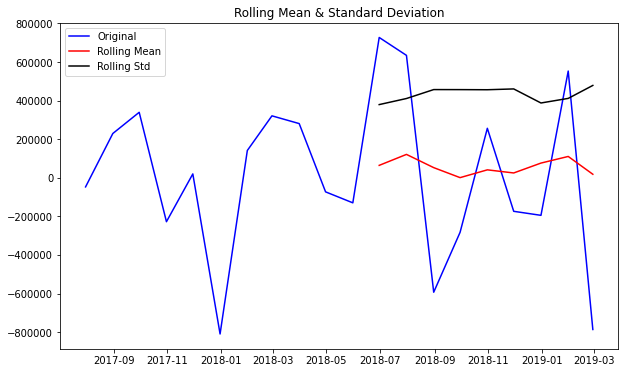

<Results of Dickey-Fuller Test>
Test Statistic                -3.22099
p-value                        0.01880
#Lags Used                     8.00000
Number of Observations Used   11.00000
Critical Value (1%)           -4.22324
Critical Value (5%)           -3.18937
Critical Value (10%)          -2.72984
dtype: float64


In [ ]:
df_temp['seasonal_first_difference'] = df_temp['first_difference'] - df_temp['first_difference'].shift(12)  
test_stationarity(df_temp.seasonal_first_difference.dropna(inplace=False))

- p값이 0.01880으로 정상 시계열로 판정

---

### [번외] 시계열 군집분석

In [ ]:
df_month = df_month.reset_index()
df_month.head()

transacted_date  store_id  real_tot_day  real_business_day  num_of_pay  \
0      2016-06-30         0            25           17.00000   145.00000   
1      2016-07-31         0            26           16.00000   178.00000   
2      2016-08-31         0            24           16.00000   171.00000   
3      2016-09-30         0            25           19.00000   160.00000   
4      2016-10-31         0            26           16.00000   167.00000   

   num_of_revisit  installment_term        amount  
0        77.00000          13.00000  747000.00000  
1       105.00000          24.00000 1005000.00000  
2        97.00000          69.00000  871571.42857  
3       103.00000          15.00000  897857.14286  
4       115.00000           9.00000  835428.57143

In [ ]:
df_train.head()

store_id  card_id card_company transacted_time  \
transacted_date                                                   
2016-06-01              0        0            b           13:13   
2016-06-01              0        1            h           18:12   
2016-06-01              0        2            c           18:52   
2016-06-01              0        3            a           20:22   
2016-06-02              0        4            c           11:06   

                 installment_term region type_of_business     amount  
transacted_date                                                       
2016-06-01                      0    NaN           기타 미용업 1857.14286  
2016-06-01                      0    NaN           기타 미용업  857.14286  
2016-06-01                      0    NaN           기타 미용업 2000.00000  
2016-06-01                      0    NaN           기타 미용업 7857.14286  
2016-06-02                      0    NaN           기타 미용업 2000.00000

In [ ]:
df_train1 = df_train.groupby(by = 'store_id')['type_of_business'].apply(lambda x: x.unique()[0]).reset_index()

In [ ]:
df_train1.head(30)

store_id        type_of_business
0          0                  기타 미용업
1          1                     NaN
2          2                     NaN
3          4                     NaN
4          5    의복 액세서리 및 모조 장신구 도매업
5          6                     NaN
6          7                     NaN
7          8                 한식 음식점업
8          9                     NaN
9         10                     NaN
10        11                     NaN
11        12         배관 및 냉ㆍ난방장치 도매업
12        13                     NaN
13        14        그 외 기타 스포츠시설 운영업
14        15                     NaN
15        16                     NaN
16        17          간이음식 포장 판매 전문점
17        18                 한식 음식점업
18        19             안경 및 렌즈 소매업
19        20                     NaN
20        22                     NaN
21        23                  기타 미용업
22        24  그 외 기타 분류 안된 상품 전문 소매업
23        25       채소, 과실 및 뿌리작물 소매업
24        26                     NaN
25        27                     NaN
26        28                     NaN
27        29                     NaN
28        30                서양식 음식점업
29        31                     NaN

In [ ]:
data = pd.merge(df_month, df_train1, how='inner', on ='store_id').dropna(axis=0)

In [ ]:
data.tail()

transacted_date  store_id  real_tot_day  real_business_day  num_of_pay  \
60910      2018-10-31      2136            31           23.00000   338.00000   
60911      2018-11-30      2136            28           20.00000   356.00000   
60912      2018-12-31      2136            31           21.00000   403.00000   
60913      2019-01-31      2136            31           23.00000   297.00000   
60914      2019-02-28      2136            28           20.00000   376.00000   

       num_of_revisit  installment_term        amount type_of_business  
60910        86.00000           0.00000 2012214.28571           기타 주점업  
60911        87.00000           0.00000 2135428.57143           기타 주점업  
60912       109.00000           0.00000 2427428.57143           기타 주점업  
60913        74.00000           3.00000 1873642.85714           기타 주점업  
60914        83.00000           0.00000 2227428.57143           기타 주점업

In [ ]:
len(set(data['type_of_business']))

145

In [ ]:
len(set(data['store_id']))

792

In [ ]:
data.to_csv('df_month_business.csv', encoding='utf-8', index=False)
data.head()

transacted_date  store_id  real_tot_day  real_business_day  num_of_pay  \
0      2016-06-30         0            25           17.00000   145.00000   
1      2016-07-31         0            26           16.00000   178.00000   
2      2016-08-31         0            24           16.00000   171.00000   
3      2016-09-30         0            25           19.00000   160.00000   
4      2016-10-31         0            26           16.00000   167.00000   

   num_of_revisit  installment_term        amount type_of_business  
0        77.00000          13.00000  747000.00000           기타 미용업  
1       105.00000          24.00000 1005000.00000           기타 미용업  
2        97.00000          69.00000  871571.42857           기타 미용업  
3       103.00000          15.00000  897857.14286           기타 미용업  
4       115.00000           9.00000  835428.57143           기타 미용업

In [ ]:
! pip install tslearn

     |████████████████████████████████| 778kB 8.2MB/s 


In [ ]:
#tslearn is a Python package that provides machine learning tools for the analysis of time series.
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
temp = pd.DataFrame(columns=list(data.columns).extend(['amount_diff']))

for i in set(data['store_id']):
    a = data[data['store_id']==i]
    a['amount_diff'] = a['amount'] - a['amount'].shift(1)
    print(a.head())
    ma = MaxAbsScaler()
    ma.fit(np.array(a[['amount_diff','amount']]))
    a[['amount_diff','amount']] = ma.transform(np.array(a[['amount_diff','amount']]))
    temp = pd.concat([temp, a], axis=0)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
38035      2016-06-30      1322            22           19.00000    51.00000   
38036      2016-07-31      1322            24           17.00000    59.00000   
38037      2016-08-31      1322            25           18.00000    62.00000   
38038      2016-09-30      1322            24           18.00000    55.00000   
38039      2016-10-31      1322            24           15.00000    45.00000   

       num_of_revisit  installment_term        amount type_of_business  \
38035         0.00000          38.00000  841428.57143         통신장비 수리업   
38036         3.00000          44.00000  896428.57143         통신장비 수리업   
38037         2.00000          62.00000 1060285.71429         통신장비 수리업   
38038         0.00000          31.00000  734428.57143         통신장비 수리업   
38039         1.00000          31.00000  645000.00000         통신장비 수리업   

        amount_diff  
38035           nan  
38036   55000.00000  
38037  163857.14286  
38038 -325857.14286  
38039  -

In [ ]:
temp.head()

transacted_date  store_id  real_tot_day  real_business_day  num_of_pay  \
0      2016-06-30         0            25           17.00000   145.00000   
1      2016-07-31         0            26           16.00000   178.00000   
2      2016-08-31         0            24           16.00000   171.00000   
3      2016-09-30         0            25           19.00000   160.00000   
4      2016-10-31         0            26           16.00000   167.00000   

   num_of_revisit  installment_term  amount type_of_business  amount_diff  
0        77.00000          13.00000 0.74328           기타 미용업          nan  
1       105.00000          24.00000 1.00000           기타 미용업      1.00000  
2        97.00000          69.00000 0.86724           기타 미용업     -0.51717  
3       103.00000          15.00000 0.89339           기타 미용업      0.10188  
4       115.00000           9.00000 0.83127           기타 미용업     -0.24197

In [ ]:
data_clustering = temp.pivot(index='store_id', columns = 'transacted_date', values='amount_diff')
data_clustering.head(20)

transacted_date  2016-06-30  2016-07-31  2016-08-31  2016-09-30  2016-10-31  \
store_id                                                                      
0                       nan     1.00000    -0.51717     0.10188    -0.24197   
5                       nan     0.31337    -0.58778    -0.10892    -0.07146   
8                       nan         nan         nan         nan         nan   
12                      nan    -0.09390     0.23334     0.55498     0.00403   
14                      nan    -0.25138    -0.04373     0.21895    -0.13741   
17                      nan     0.05362    -0.01535     0.54943    -0.41777   
18                      nan         nan         nan         nan         nan   
19                      nan         nan         nan         nan         nan   
23                      nan    -0.20682     0.26819    -0.27129     0.02272   
24                      nan     0.01623     0.01260     0.10719    -0.14970   
25                      nan         nan         nan         nan         nan   
30                      nan    -0.36884     0.10323    -1.00000     0.41441   
32                      nan     0.23544    -0.10080     0.03889     0.55392   
33                      nan    -0.39833     0.02870     0.25917     0.12751   
34                      nan     0.18049    -0.26600    -0.42908     0.58706   
35                      nan    -0.31453    -0.01643    -0.31338     0.09332   
37                      nan         nan     0.25729     1.00000    -0.94430   
40                      nan     0.12939    -0.40434    -0.00523     0.19813   
42                      nan     0.69581     0.11783    -0.46904     0.62185   
45                      nan     0.47929     0.11102     0.58737    -0.89155   

transacted_date  2016-11-30  2016-12-31  2017-01-31  2017-02-28  2017-03-31  \
store_id                                                                      
0                  -0.53654     0.25138    -0.68300     0.80759    -0.28583   
5                  -0.10242    -0.11989    -0.09245     0.22742    -0.06054   
8                       nan     0.55951    -0.27582     0.00802     0.13176   
12                 -0.02342    -0.77324    -0.21056    -0.03373    -0.01649   
14                 -0.03317     0.32142     0.03613    -0.03218    -0.49358   
17                 -0.30775     0.19318    -0.35276    -0.14189     0.52594   
18                      nan     0.33881     0.07153    -0.18361     0.07679   
19                      nan         nan         nan     0.40612     0.03707   
23                 -0.24012     0.42551    -0.27756     0.64291    -0.18694   
24                  0.06216     0.28907     0.32682     0.32555     1.00000   
25                      nan         nan         nan         nan     0.08248   
30                  0.04986     0.07432     0.29068    -0.03238    -0.13127   
32                 -0.54884     0.43066     0.03839    -0.52822    -0.01516   
33                  0.08808     0.15001    -0.05625     0.07969    -0.10029   
34                 -0.11326     0.12998    -0.56405     1.00000    -0.23454   
35                 -0.01082    -0.34757    -0.17292     0.50368     0.09892   
37                  0.02355     0.73733    -0.21946    -0.41772     0.29432   
40                 -0.02748    -0.53682    -0.44568     0.13161     0.32420   
42                 -0.64794     0.62758    -0.56537    -0.46416     1.00000   
45                 -0.02891    -0.34450     0.35297     0.27398    -0.53894   

transacted_date  2017-04-30  2017-05-31  2017-06-30  2017-07-31  2017-08-31  \
store_id                                                                      
0                  -0.13555     0.22924    -0.24197     0.17940     0.08029   
5                   0.49970    -0.26925     0.83545    -0.22559    -0.39321   
8                   0.48554     0.07206    -0.11711     0.35517    -0.30570   
12                  0.13155    -0.13155     0.20734    -0.10000     0.15054   
14                 -0.03552     0.34047    -0.02

In [ ]:
print(len(data_clustering))
data_clustering = data_clustering.iloc[:, 1:].dropna(axis=0)
print(len(data_clustering))

792
577


In [ ]:
def look_up_value(x):
  return temp[temp['store_id']==x]['type_of_business'].unique()[0]

data_clustering['type_of_business'] = data_clustering.reset_index()['store_id'].apply(lambda x: look_up_value(x))

In [ ]:
data_clustering.head()

transacted_date  2016-07-31 00:00:00  2016-08-31 00:00:00  \
store_id                                                    
0                            1.00000             -0.51717   
5                            0.31337             -0.58778   
12                          -0.09390              0.23334   
14                          -0.25138             -0.04373   
17                           0.05362             -0.01535   

transacted_date  2016-09-30 00:00:00  2016-10-31 00:00:00  \
store_id                                                    
0                            0.10188             -0.24197   
5                           -0.10892             -0.07146   
12                           0.55498              0.00403   
14                           0.21895             -0.13741   
17                           0.54943             -0.41777   

transacted_date  2016-11-30 00:00:00  2016-12-31 00:00:00  \
store_id                                                    
0                           -0.53654              0.25138   
5                           -0.10242             -0.11989   
12                          -0.02342             -0.77324   
14                          -0.03317              0.32142   
17                          -0.30775              0.19318   

transacted_date  2017-01-31 00:00:00  2017-02-28 00:00:00  \
store_id                                                    
0                           -0.68300              0.80759   
5                           -0.09245              0.22742   
12                          -0.21056             -0.03373   
14                           0.03613             -0.03218   
17                          -0.35276             -0.14189   

transacted_date  2017-03-31 00:00:00  2017-04-30 00:00:00  \
store_id                                                    
0                           -0.28583             -0.13555   
5                           -0.06054              0.49970   
12                          -0.01649              0.13155   
14                          -0.49358             -0.03552   
17                           0.52594              0.38241   

transacted_date  2017-05-31 00:00:00  2017-06-30 00:00:00  \
store_id                                                    
0                            0.22924             -0.24197   
5                           -0.26925              0.83545   
12                          -0.13155              0.20734   
14                           0.34047             -0.02678   
17                          -0.25459              0.41393   

transacted_date  2017-07-31 00:00:00  2017-08-31 00:00:00  \
store_id                                                    
0                            0.17940              0.08029   
5                           -0.22559             -0.39321   
12                          -0.10000              0.15054   
14                           0.18724              0.26479   
17                          -0.12770              0.82740   

transacted_date  2017-09-30 00:00:00  2017-10-31 00:00:00  \
store_id                                                    
0                            0.35604             -0.93134   
5                           -0.02183              0.36379   
12                           0.31816             -0.11663   
14                          -0.27454             -0.15690   
17                          -0.70202              0.34427   

transacted_date  2017-11-30 00:00:00  2017-12-31 00:00:00  \
store_id                                                    
0                            0.11739              0.70487   
5                            0.01087              0.14683   
12                          -0.26664              0.75887   
14                           0.28787             -0.12578   
17                          -0.58758              0.17667   

transacted_date  2018-01-31 00:00:00  2018-02-28 00:00:00  \
store_id                                                    
0                         

In [ ]:
data_clustering = data_clustering.reset_index().iloc[:,1:].groupby(by='type_of_business').mean()
data_clustering.head()

transacted_date     2016-07-31 00:00:00  2016-08-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.17717             -0.04071   
가정용 직물제품 소매업                   -0.06396              0.12826   
간이음식 포장 판매 전문점                 -0.23563              0.04351   
건강보조식품 소매업                     -0.36582              0.22959   
게임용구, 인형 및 장난감 소매업              0.12082             -0.63883   

transacted_date     2016-09-30 00:00:00  2016-10-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.22528             -0.24192   
가정용 직물제품 소매업                   -0.58094              0.46555   
간이음식 포장 판매 전문점                 -0.14228             -0.03080   
건강보조식품 소매업                     -0.19863             -0.06569   
게임용구, 인형 및 장난감 소매업             -0.29582              0.46764   

transacted_date     2016-11-30 00:00:00  2016-12-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.34144             -0.21576   
가정용 직물제품 소매업                    0.03726             -0.22024   
간이음식 포장 판매 전문점                  0.12535              0.22177   
건강보조식품 소매업                      0.24597             -0.16052   
게임용구, 인형 및 장난감 소매업             -0.08607              0.06248   

transacted_date     2017-01-31 00:00:00  2017-02-28 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.34790             -0.08907   
가정용 직물제품 소매업                    0.57567             -0.87669   
간이음식 포장 판매 전문점                 -0.36383              0.07589   
건강보조식품 소매업                      0.29305              0.02799   
게임용구, 인형 및 장난감 소매업              0.01211             -0.17565   

transacted_date     2017-03-31 00:00:00  2017-04-30 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.49265              0.37221   
가정용 직물제품 소매업                    1.00000             -0.28981   
간이음식 포장 판매 전문점                  0.19880             -0.30645   
건강보조식품 소매업                     -0.13912              0.04939   
게임용구, 인형 및 장난감 소매업              0.58719             -0.13899   

transacted_date     2017-05-31 00:00:00  2017-06-30 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.16727              0.08617   
가정용 직물제품 소매업                    0.03660              0.50907   
간이음식 포장 판매 전문점                  0.47446             -0.34810   
건강보조식품 소매업                     -0.10421              0.32466   
게임용구, 인형 및 장난감 소매업             -0.36245              0.37169   

transacted_date     2017-07-31 00:00:00  2017-08-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.21216              0.51186   
가정용 직물제품 소매업                   -0.01945             -0.31124   
간이음식 포장 판매 전문점                 -0.03641              0.24311   
건강보조식품 소매업                      0.17246             -0.38294   
게임용구, 인형 및 장난감 소매업             -0.26650             -0.21135   

transacted_date     2017-09-30 00:00:00  2017-10-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.84555              0.19849   
가정용 직물제품 소매업                   -0.09133             -0.27992   
간이음식 포장 판매 전문점                 -0.27160             -0.07700   
건강보조식품 소매업                      0.07318             -0.04495   
게임용구, 인형 및 장난감 소매업              0.46159             -1.00000   

transacted_date     2017-11-30 00:00:00  2017-12-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.41745              0.42670   
가정용 직물제품 소매업                    0.08770              0.14639   
간이음식 포장 판매 전문점                  0.02803             -0.04931   
건강보조식품 소매업                      0.30803             -0.53276   
게임용구, 인형 및 장난감 소매업      

In [ ]:
temp.head()

transacted_date  store_id  real_tot_day  real_business_day  num_of_pay  \
0      2016-06-30         0            25           17.00000   145.00000   
1      2016-07-31         0            26           16.00000   178.00000   
2      2016-08-31         0            24           16.00000   171.00000   
3      2016-09-30         0            25           19.00000   160.00000   
4      2016-10-31         0            26           16.00000   167.00000   

   num_of_revisit  installment_term  amount type_of_business  amount_diff  
0        77.00000          13.00000 0.74328           기타 미용업          nan  
1       105.00000          24.00000 1.00000           기타 미용업      1.00000  
2        97.00000          69.00000 0.86724           기타 미용업     -0.51717  
3       103.00000          15.00000 0.89339           기타 미용업      0.10188  
4       115.00000           9.00000 0.83127           기타 미용업     -0.24197

In [ ]:
temp.to_csv('월단위리샘플링.csv', index=False, encoding='utf-8')
data_clustering.to_csv('업종별 1개월 차분 maxabs scaling.csv', index=False, encoding='utf-8')

In [ ]:
data_clustering.head()

transacted_date     2016-07-31 00:00:00  2016-08-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.17717             -0.04071   
가정용 직물제품 소매업                   -0.06396              0.12826   
간이음식 포장 판매 전문점                 -0.23563              0.04351   
건강보조식품 소매업                     -0.36582              0.22959   
게임용구, 인형 및 장난감 소매업              0.12082             -0.63883   

transacted_date     2016-09-30 00:00:00  2016-10-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.22528             -0.24192   
가정용 직물제품 소매업                   -0.58094              0.46555   
간이음식 포장 판매 전문점                 -0.14228             -0.03080   
건강보조식품 소매업                     -0.19863             -0.06569   
게임용구, 인형 및 장난감 소매업             -0.29582              0.46764   

transacted_date     2016-11-30 00:00:00  2016-12-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.34144             -0.21576   
가정용 직물제품 소매업                    0.03726             -0.22024   
간이음식 포장 판매 전문점                  0.12535              0.22177   
건강보조식품 소매업                      0.24597             -0.16052   
게임용구, 인형 및 장난감 소매업             -0.08607              0.06248   

transacted_date     2017-01-31 00:00:00  2017-02-28 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.34790             -0.08907   
가정용 직물제품 소매업                    0.57567             -0.87669   
간이음식 포장 판매 전문점                 -0.36383              0.07589   
건강보조식품 소매업                      0.29305              0.02799   
게임용구, 인형 및 장난감 소매업              0.01211             -0.17565   

transacted_date     2017-03-31 00:00:00  2017-04-30 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.49265              0.37221   
가정용 직물제품 소매업                    1.00000             -0.28981   
간이음식 포장 판매 전문점                  0.19880             -0.30645   
건강보조식품 소매업                     -0.13912              0.04939   
게임용구, 인형 및 장난감 소매업              0.58719             -0.13899   

transacted_date     2017-05-31 00:00:00  2017-06-30 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.16727              0.08617   
가정용 직물제품 소매업                    0.03660              0.50907   
간이음식 포장 판매 전문점                  0.47446             -0.34810   
건강보조식품 소매업                     -0.10421              0.32466   
게임용구, 인형 및 장난감 소매업             -0.36245              0.37169   

transacted_date     2017-07-31 00:00:00  2017-08-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.21216              0.51186   
가정용 직물제품 소매업                   -0.01945             -0.31124   
간이음식 포장 판매 전문점                 -0.03641              0.24311   
건강보조식품 소매업                      0.17246             -0.38294   
게임용구, 인형 및 장난감 소매업             -0.26650             -0.21135   

transacted_date     2017-09-30 00:00:00  2017-10-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.84555              0.19849   
가정용 직물제품 소매업                   -0.09133             -0.27992   
간이음식 포장 판매 전문점                 -0.27160             -0.07700   
건강보조식품 소매업                      0.07318             -0.04495   
게임용구, 인형 및 장난감 소매업              0.46159             -1.00000   

transacted_date     2017-11-30 00:00:00  2017-12-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.41745              0.42670   
가정용 직물제품 소매업                    0.08770              0.14639   
간이음식 포장 판매 전문점                  0.02803             -0.04931   
건강보조식품 소매업                      0.30803             -0.53276   
게임용구, 인형 및 장난감 소매업      

In [ ]:
data_clustering.isnull().sum()

transacted_date
2016-07-31    0
2016-08-31    0
2016-09-30    0
2016-10-31    0
2016-11-30    0
2016-12-31    0
2017-01-31    0
2017-02-28    0
2017-03-31    0
2017-04-30    0
2017-05-31    0
2017-06-30    0
2017-07-31    0
2017-08-31    0
2017-09-30    0
2017-10-31    0
2017-11-30    0
2017-12-31    0
2018-01-31    0
2018-02-28    0
2018-03-31    0
2018-04-30    0
2018-05-31    0
2018-06-30    0
2018-07-31    0
2018-08-31    0
2018-09-30    0
2018-10-31    0
2018-11-30    0
2018-12-31    0
2019-01-31    0
2019-02-28    0
dtype: int64

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished


3.589 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    0.0s finished


1.818 --> 1.818 --> 
2.267 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.759 --> 1.689 --> 1.684 --> 

[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished


1.684 --> 
2.072 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished


1.613 --> 1.590 --> 1.587 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.587 --> 
1.963 --> 

[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished


1.553 --> 1.516 --> 1.498 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1.498 --> 


[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:    0.1s finished


1.856 --> 1.499 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.462 --> 1.439 --> 1.438 --> 

[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.438 --> 


[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:    0.1s finished


1.777 --> 1.427 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.381 --> 1.368 --> 1.366 --> 

[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.365 --> 1.365 --> 


[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

1.701 --> 1.345 --> 

[Parallel(n_jobs=1)]: Done 469 out of 469 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 469 out of 469 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.311 --> 1.300 --> 1.300 --> 

[Parallel(n_jobs=1)]: Done 469 out of 469 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 469 out of 469 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 469 out of 469 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

1.609 --> 1.279 --> 

[Parallel(n_jobs=1)]: Done 536 out of 536 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 536 out of 536 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.235 --> 1.219 --> 

[Parallel(n_jobs=1)]: Done 536 out of 536 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 536 out of 536 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 536 out of 536 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.219 --> 


[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

1.539 --> 1.203 --> 

[Parallel(n_jobs=1)]: Done 603 out of 603 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 603 out of 603 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.175 --> 1.171 --> 

[Parallel(n_jobs=1)]: Done 603 out of 603 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 603 out of 603 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.164 --> 1.161 --> 

[Parallel(n_jobs=1)]: Done 603 out of 603 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 603 out of 603 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 603 out of 603 | elapsed:    0.1s finished


1.161 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1.477 --> 1.130 --> 

[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.118 --> 1.112 --> 

[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.112 --> 


[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

1.427 --> 1.098 --> 

[Parallel(n_jobs=1)]: Done 737 out of 737 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 737 out of 737 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.088 --> 1.088 --> 


[Parallel(n_jobs=1)]: Done 737 out of 737 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

1.373 --> 1.065 --> 

[Parallel(n_jobs=1)]: Done 804 out of 804 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 804 out of 804 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.056 --> 1.056 --> 


[Parallel(n_jobs=1)]: Done 804 out of 804 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

1.330 --> 1.036 --> 

[Parallel(n_jobs=1)]: Done 871 out of 871 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 871 out of 871 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.026 --> 1.026 --> 


[Parallel(n_jobs=1)]: Done 871 out of 871 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 871 out of 871 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

1.297 --> 1.005 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 938 out of 938 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.986 --> 0.979 --> 

[Parallel(n_jobs=1)]: Done 938 out of 938 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 938 out of 938 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.979 --> 


[Parallel(n_jobs=1)]: Done 938 out of 938 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

1.255 --> 0.948 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1005 out of 1005 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.939 --> 0.939 --> 


[Parallel(n_jobs=1)]: Done 1005 out of 1005 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1005 out of 1005 | elapsed:    0.1s finished


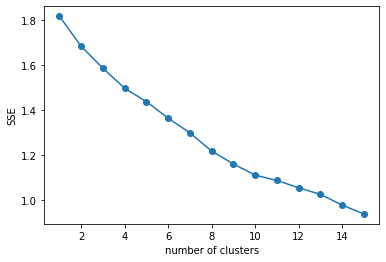

In [ ]:
# 클러스터 내 오차제곱합을 구하는 그래프 그리기
def elbow(x):
  sse = []
  for i in range(1, 16):
    km = TimeSeriesKMeans(n_clusters=i, verbose=True, random_state=1, metric='dtw')
    km.fit(x)
    sse.append(km.inertia_)

  plt.plot(range(1, 16), sse, marker='o')
  plt.xlabel('number of clusters')
  plt.ylabel('SSE')
  plt.show()

elbow(data_clustering)

In [ ]:
km = TimeSeriesKMeans(n_clusters=10, verbose=True, random_state=1, metric="dtw")
y_pred = km.fit_predict(data_clustering)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1.477 --> 1.130 --> 

[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.118 --> 1.112 --> 1.112 --> 


[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:    0.1s finished


In [ ]:
print(km.labels_)
print(len(km.labels_))

[9 1 2 8 4 9 5 9 5 3 8 9 3 0 2 7 7 2 2 3 9 3 9 1 3 9 2 6 1 9 5 9 4 1 4 5 3
 0 9 1 3 9 1 5 2 8 6 2 9 3 1 9 2 5 9 3 2 3 1 8 5 8 2 3 2 4 1]
67


In [ ]:
data_clustering.head()

transacted_date     2016-07-31 00:00:00  2016-08-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.17717             -0.04071   
가정용 직물제품 소매업                   -0.06396              0.12826   
간이음식 포장 판매 전문점                 -0.23563              0.04351   
건강보조식품 소매업                     -0.36582              0.22959   
게임용구, 인형 및 장난감 소매업              0.12082             -0.63883   

transacted_date     2016-09-30 00:00:00  2016-10-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.22528             -0.24192   
가정용 직물제품 소매업                   -0.58094              0.46555   
간이음식 포장 판매 전문점                 -0.14228             -0.03080   
건강보조식품 소매업                     -0.19863             -0.06569   
게임용구, 인형 및 장난감 소매업             -0.29582              0.46764   

transacted_date     2016-11-30 00:00:00  2016-12-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.34144             -0.21576   
가정용 직물제품 소매업                    0.03726             -0.22024   
간이음식 포장 판매 전문점                  0.12535              0.22177   
건강보조식품 소매업                      0.24597             -0.16052   
게임용구, 인형 및 장난감 소매업             -0.08607              0.06248   

transacted_date     2017-01-31 00:00:00  2017-02-28 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.34790             -0.08907   
가정용 직물제품 소매업                    0.57567             -0.87669   
간이음식 포장 판매 전문점                 -0.36383              0.07589   
건강보조식품 소매업                      0.29305              0.02799   
게임용구, 인형 및 장난감 소매업              0.01211             -0.17565   

transacted_date     2017-03-31 00:00:00  2017-04-30 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.49265              0.37221   
가정용 직물제품 소매업                    1.00000             -0.28981   
간이음식 포장 판매 전문점                  0.19880             -0.30645   
건강보조식품 소매업                     -0.13912              0.04939   
게임용구, 인형 및 장난감 소매업              0.58719             -0.13899   

transacted_date     2017-05-31 00:00:00  2017-06-30 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.16727              0.08617   
가정용 직물제품 소매업                    0.03660              0.50907   
간이음식 포장 판매 전문점                  0.47446             -0.34810   
건강보조식품 소매업                     -0.10421              0.32466   
게임용구, 인형 및 장난감 소매업             -0.36245              0.37169   

transacted_date     2017-07-31 00:00:00  2017-08-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.21216              0.51186   
가정용 직물제품 소매업                   -0.01945             -0.31124   
간이음식 포장 판매 전문점                 -0.03641              0.24311   
건강보조식품 소매업                      0.17246             -0.38294   
게임용구, 인형 및 장난감 소매업             -0.26650             -0.21135   

transacted_date     2017-09-30 00:00:00  2017-10-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.84555              0.19849   
가정용 직물제품 소매업                   -0.09133             -0.27992   
간이음식 포장 판매 전문점                 -0.27160             -0.07700   
건강보조식품 소매업                      0.07318             -0.04495   
게임용구, 인형 및 장난감 소매업              0.46159             -1.00000   

transacted_date     2017-11-30 00:00:00  2017-12-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.41745              0.42670   
가정용 직물제품 소매업                    0.08770              0.14639   
간이음식 포장 판매 전문점                  0.02803             -0.04931   
건강보조식품 소매업                      0.30803             -0.53276   
게임용구, 인형 및 장난감 소매업      

In [ ]:
business_list = list(data_clustering.reset_index()['type_of_business'])
label_list = list(km.labels_)

In [ ]:
_dict = dict(zip(business_list, label_list))

In [ ]:
for k in range(0, 10):
  print('label', k)
  for i, j in _dict.items():
    if j == k:
      print(i)
  print('-' * 40)

label 0
기타 건물 관련설비 설치 공사업
악기 도매업
----------------------------------------
label 1
가정용 직물제품 소매업
노래연습장 운영업
비알코올 음료점업
섬유, 직물 및 의복액세서리 소매업
여행사업
유아용 의류 소매업
자동차 종합 수리업
커튼 및 침구용품 도매업
화훼류 및 식물 도매업
----------------------------------------
label 2
간이음식 포장 판매 전문점
기타 교습학원
기타 미용업
기타 스포츠 교육기관
두발 미용업
의복 소매업
일반 교과 학원
자전거 및 기타 운송장비 도매업
체형 등 기타 신체관리 서비스업
한식 음식점업
화장품, 비누 및 방향제 소매업
----------------------------------------
label 3
그 외 기타 분류 안된 상품 전문 소매업
기념품, 관광 민예품 및 장식용품 소매업
기타 예술학원
기타 주점업
담배 소매업
신발 소매업
외국어학원
자동차 전문 수리업
체력단련시설 운영업
치킨 전문점
화장품 및 화장용품 도매업
----------------------------------------
label 4
게임용구, 인형 및 장난감 소매업
서적, 신문 및 잡지류 소매업
수영장 운영업
화초 및 식물 소매업
----------------------------------------
label 5
그 외 기타 달리 분류되지 않은 개인 서비스업
그 외 기타 분류 안된 사업지원 서비스업
상품 종합 도매업
시계 및 귀금속 소매업
의료용품 도매업
전자상거래 소매업
컴퓨터 학원
----------------------------------------
label 6
문구용품, 회화용품, 사무용품·· 도매업
인물사진 및 행사용 영상 촬영업
----------------------------------------
label 7
기타 교육지원 서비스업
기타 기술 및 직업훈련학원
----------------------------------------
l

In [ ]:
data_clustering['label'] = np.array(label_list)
data_clustering.head()

transacted_date     2016-07-31 00:00:00  2016-08-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.17717             -0.04071   
가정용 직물제품 소매업                   -0.06396              0.12826   
간이음식 포장 판매 전문점                 -0.23563              0.04351   
건강보조식품 소매업                     -0.36582              0.22959   
게임용구, 인형 및 장난감 소매업              0.12082             -0.63883   

transacted_date     2016-09-30 00:00:00  2016-10-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.22528             -0.24192   
가정용 직물제품 소매업                   -0.58094              0.46555   
간이음식 포장 판매 전문점                 -0.14228             -0.03080   
건강보조식품 소매업                     -0.19863             -0.06569   
게임용구, 인형 및 장난감 소매업             -0.29582              0.46764   

transacted_date     2016-11-30 00:00:00  2016-12-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.34144             -0.21576   
가정용 직물제품 소매업                    0.03726             -0.22024   
간이음식 포장 판매 전문점                  0.12535              0.22177   
건강보조식품 소매업                      0.24597             -0.16052   
게임용구, 인형 및 장난감 소매업             -0.08607              0.06248   

transacted_date     2017-01-31 00:00:00  2017-02-28 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.34790             -0.08907   
가정용 직물제품 소매업                    0.57567             -0.87669   
간이음식 포장 판매 전문점                 -0.36383              0.07589   
건강보조식품 소매업                      0.29305              0.02799   
게임용구, 인형 및 장난감 소매업              0.01211             -0.17565   

transacted_date     2017-03-31 00:00:00  2017-04-30 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.49265              0.37221   
가정용 직물제품 소매업                    1.00000             -0.28981   
간이음식 포장 판매 전문점                  0.19880             -0.30645   
건강보조식품 소매업                     -0.13912              0.04939   
게임용구, 인형 및 장난감 소매업              0.58719             -0.13899   

transacted_date     2017-05-31 00:00:00  2017-06-30 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.16727              0.08617   
가정용 직물제품 소매업                    0.03660              0.50907   
간이음식 포장 판매 전문점                  0.47446             -0.34810   
건강보조식품 소매업                     -0.10421              0.32466   
게임용구, 인형 및 장난감 소매업             -0.36245              0.37169   

transacted_date     2017-07-31 00:00:00  2017-08-31 00:00:00  \
type_of_business                                               
가정용 세탁업                         0.21216              0.51186   
가정용 직물제품 소매업                   -0.01945             -0.31124   
간이음식 포장 판매 전문점                 -0.03641              0.24311   
건강보조식품 소매업                      0.17246             -0.38294   
게임용구, 인형 및 장난감 소매업             -0.26650             -0.21135   

transacted_date     2017-09-30 00:00:00  2017-10-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.84555              0.19849   
가정용 직물제품 소매업                   -0.09133             -0.27992   
간이음식 포장 판매 전문점                 -0.27160             -0.07700   
건강보조식품 소매업                      0.07318             -0.04495   
게임용구, 인형 및 장난감 소매업              0.46159             -1.00000   

transacted_date     2017-11-30 00:00:00  2017-12-31 00:00:00  \
type_of_business                                               
가정용 세탁업                        -0.41745              0.42670   
가정용 직물제품 소매업                    0.08770              0.14639   
간이음식 포장 판매 전문점                  0.02803             -0.04931   
건강보조식품 소매업                      0.30803             -0.53276   
게임용구, 인형 및 장난감 소매업      

In [ ]:
data_vis = data_clustering.reset_index().melt(id_vars=['type_of_business', 'label'],
                                               var_name = 'transacted_date',
                                               value_name = 'amount')
data_vis = data_vis.sort_values(by=['label', 'type_of_business', 'transacted_date'], ascending = True)
data_vis.head()

type_of_business  label transacted_date   amount
13   기타 건물 관련설비 설치 공사업      0      2016-07-31  0.15945
80   기타 건물 관련설비 설치 공사업      0      2016-08-31 -0.31434
147  기타 건물 관련설비 설치 공사업      0      2016-09-30  0.49119
214  기타 건물 관련설비 설치 공사업      0      2016-10-31 -0.02349
281  기타 건물 관련설비 설치 공사업      0      2016-11-30  0.72874

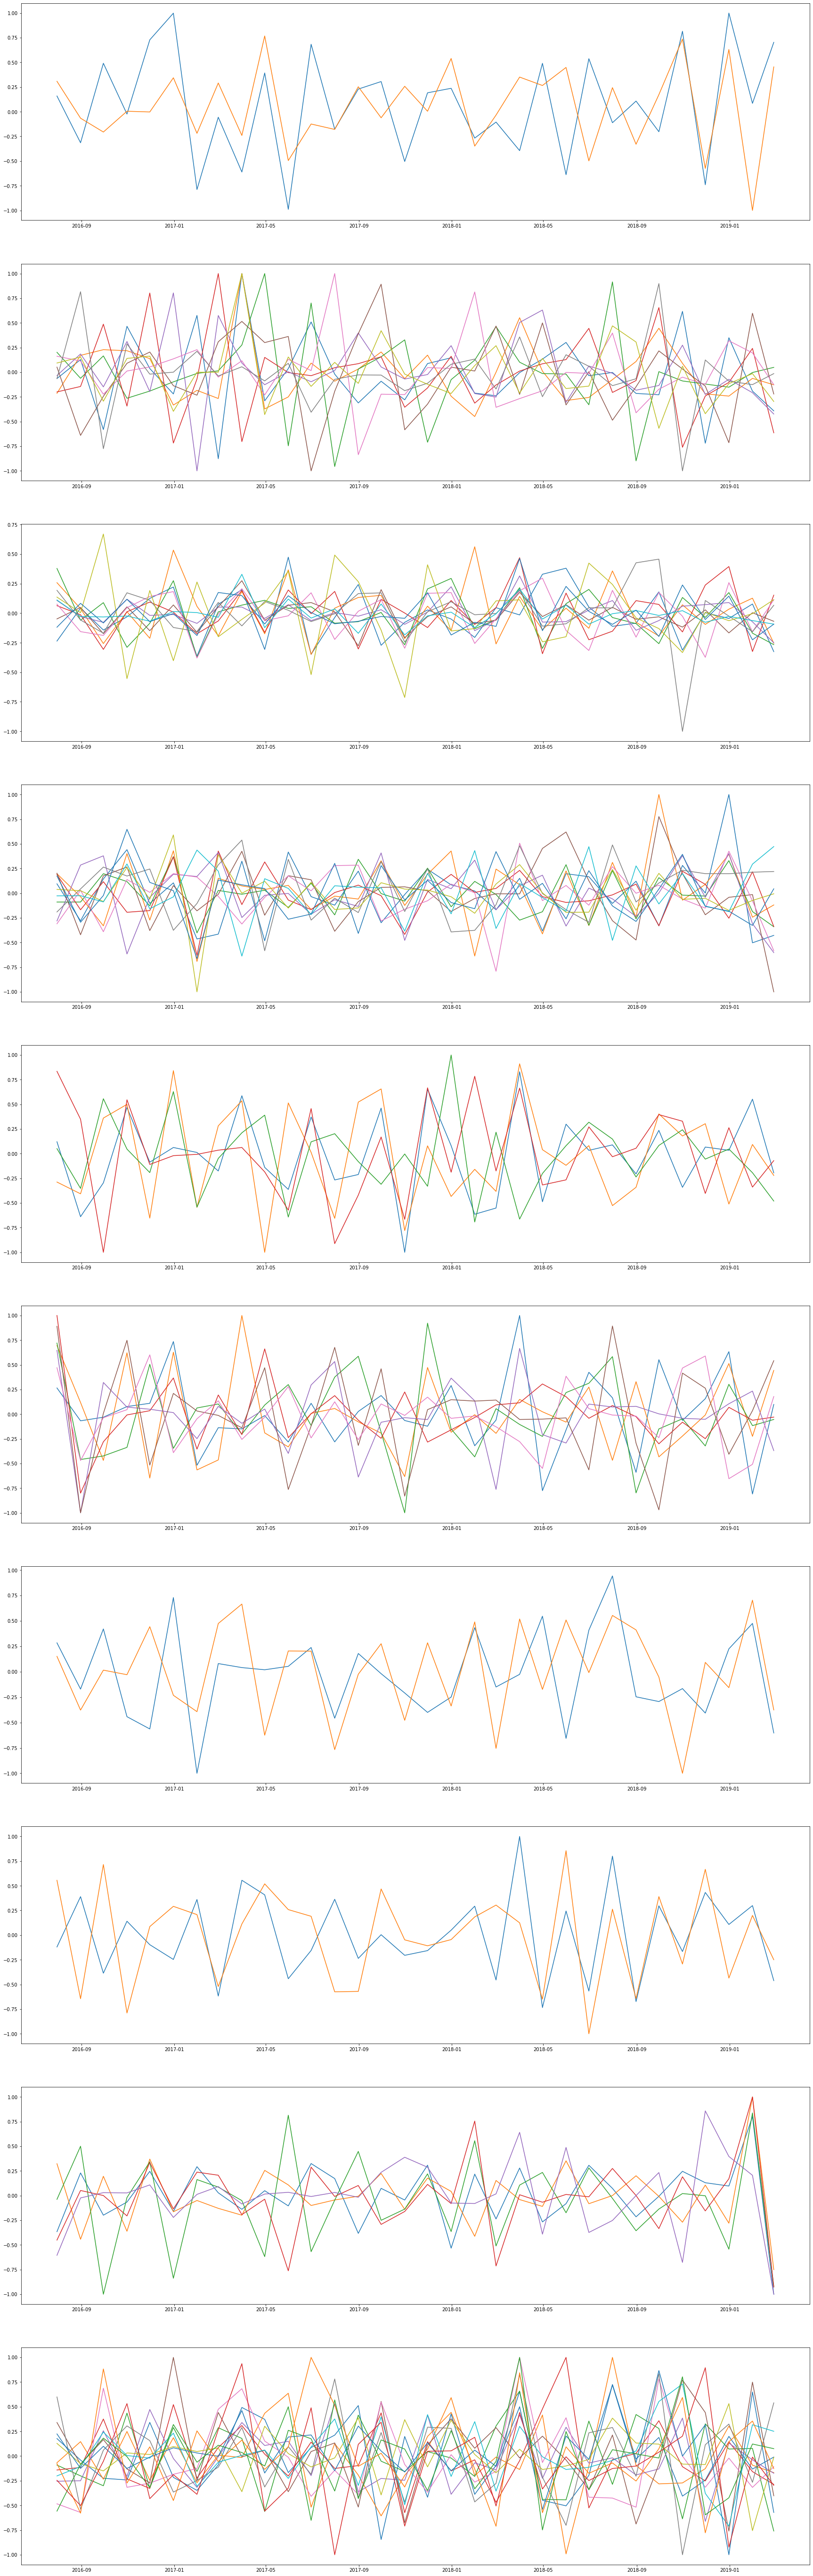

In [ ]:
fig = plt.figure(figsize=(30, 100))

def make_subplot(label):
  ax = fig.add_subplot(10, 1, label + 1)
  a = data_vis[data_vis['label'] == label]
  for i in a['type_of_business'].unique():
    ax.plot(a[a['type_of_business'] == i]['transacted_date'], a[a['type_of_business']==i]['amount'])

for label in range(0, 10):
  make_subplot(label)

plt.show()

최적 클러스터 3, 10번째 라벨